<a href="https://colab.research.google.com/github/nimrashaheen001/Programming_for_AI/blob/main/thesisfusion3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_path = '/content/Data-1.zip'
extract_path = '/content/dataset'

if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print("❌ The file is not a valid zip file.")

Extraction complete.


In [ ]:
import pandas as pd
import glob, os

# 1) Load tabular data
tab_lookup = pd.read_csv("/content/tabular.csv")

# 2) Normalize ImageID column
tab_lookup['ImageID'] = tab_lookup['ImageID'].astype(str)

# If your CSV has no extension, but your dataset has .png
tab_lookup['ImageID'] = tab_lookup['ImageID'].apply(lambda x: x if x.endswith(".png") else x + ".png")

# If CSV has .jpg but dataset has .png
# tab_lookup['ImageID'] = tab_lookup['ImageID'].str.replace(".jpg", ".png")

# 3) Check matching
img_files = [os.path.basename(f) for f in glob.glob("/content/images/*/*")]  # adjust to your path
img_set = set(img_files)
tab_set = set(tab_lookup['ImageID'])

print("CSV sample:", list(tab_set)[:5])
print("Image sample:", list(img_set)[:5])
print("Overlap:", len(img_set & tab_set))


CSV sample: ['OAS1_0031_MR1_mpr-1_147.jpg.png', 'OAS1_0052_MR1_mpr-1_106.jpg.png', 'OAS1_0021_MR1_mpr-3_157.jpg.png', 'OAS1_0001_MR1_mpr-3_112.jpg.png', 'OAS1_0028_MR1_mpr-2_123.jpg.png']
Image sample: []
Overlap: 0


In [ ]:
import glob

# Recursively search for images under /content
all_imgs = glob.glob("/content/**/*.png", recursive=True) + glob.glob("/content/**/*.jpg", recursive=True)

print("Total images found:", len(all_imgs))
print("Sample paths:", all_imgs[:5])

Total images found: 2982
Sample paths: ['/content/dataset/Data/Data/AD/OAS1_0003_MR1_mpr-1_128.jpg', '/content/dataset/Data/Data/AD/OAS1_0021_MR1_mpr-3_117.jpg', '/content/dataset/Data/Data/AD/OAS1_0003_MR1_mpr-1_156.jpg', '/content/dataset/Data/Data/AD/OAS1_0022_MR1_mpr-1_156.jpg', '/content/dataset/Data/Data/AD/OAS1_0015_MR1_mpr-1_112.jpg']


In [ ]:
import pandas as pd
import os
import glob

# === 1. Load your CSV ===
csv_path = "/content/tabular.csv"   # change if different
tab_lookup = pd.read_csv(csv_path)

print("[Before] Shape:", tab_lookup.shape)
print("[Before] Sample IDs:", tab_lookup['ImageID'].head().tolist())

# === 2. Clean ImageID column ===
# remove double extensions like ".jpg.png"
tab_lookup['ImageID'] = tab_lookup['ImageID'].str.replace(".jpg.png", ".jpg", regex=False)

# normalize to lowercase (in case your files are lowercase)
tab_lookup['ImageID'] = tab_lookup['ImageID'].str.lower()

print("[After] Sample IDs:", tab_lookup['ImageID'].head().tolist())

# === 3. Collect real image filenames ===
all_imgs = glob.glob("/content/dataset/Data/Data/**/*.jpg", recursive=True)
img_files = [os.path.basename(f).lower() for f in all_imgs]

print("Total images found:", len(img_files))
print("Sample real files:", img_files[:5])

# === 4. Verify overlap ===
tab_set = set(tab_lookup['ImageID'])
img_set = set(img_files)
overlap = tab_set & img_set

print(f"[Check] CSV IDs: {len(tab_set)}, Image files: {len(img_set)}, Overlap: {len(overlap)}")

if len(overlap) == 0:
    print("❌ Still no overlap! Check extensions or path issues.")
else:
    print("✅ Overlap found:", len(overlap))

# === 5. Save fixed CSV ===
fixed_path = "/content/tabular_fixed.csv"
tab_lookup.to_csv(fixed_path, index=False)
print(f"✅ Fixed CSV saved to {fixed_path}")


[Before] Shape: (2982, 9)
[Before] Sample IDs: ['OAS1_0003_MR1_mpr-1_100.jpg', 'OAS1_0003_MR1_mpr-1_101.jpg', 'OAS1_0003_MR1_mpr-1_102.jpg', 'OAS1_0003_MR1_mpr-1_103.jpg', 'OAS1_0003_MR1_mpr-1_104.jpg']
[After] Sample IDs: ['oas1_0003_mr1_mpr-1_100.jpg', 'oas1_0003_mr1_mpr-1_101.jpg', 'oas1_0003_mr1_mpr-1_102.jpg', 'oas1_0003_mr1_mpr-1_103.jpg', 'oas1_0003_mr1_mpr-1_104.jpg']
Total images found: 2982
Sample real files: ['oas1_0005_mr1_mpr-4_156.jpg', 'oas1_0006_mr1_mpr-1_107.jpg', 'oas1_0002_mr1_mpr-1_105.jpg', 'oas1_0005_mr1_mpr-2_114.jpg', 'oas1_0004_mr1_mpr-2_141.jpg']
[Check] CSV IDs: 2982, Image files: 2982, Overlap: 2982
✅ Overlap found: 2982
✅ Fixed CSV saved to /content/tabular_fixed.csv


In [ ]:
tab_lookup = pd.read_csv("/content/tabular_fixed.csv")


In [ ]:
# ================================
# Multimodal TransUNet + TabNet Top-K Fusion (Robust ID/Class Fix)
# ================================
# - Auto-fixes CSV ↔ image filename mismatches (case, extensions, double extensions)
# - Auto-maps class label aliases (e.g., MCI <-> MCI-1)
# - Concatenates TransUNet CLS embeddings + top-k tabular features
# - Early stopping + test metrics

import os
import re
import random
from pathlib import Path
from typing import Dict, Optional, List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

# ----------------
# Config
# ----------------
class Cfg:
    # Paths
    data_root = "/content/dataset/Data/Data"
    tabular_csv = "/content/tabular_fixed.csv"           # full tabular file
    topk_csv    = "/content/tabular_top10_features.csv"  # optional (from TabNet)
    id_col = "ImageID"
    target_col = "Class"   # your CSV uses "Class"
    # Image
    img_size = 224
    in_channels = 3
    # Train
    batch_size = 16
    num_workers = 2
    seed = 42
    epochs = 100
    patience = 6
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Optim
    lr_head = 1e-4
    lr_backbone = 1e-5
    weight_decay = 1e-4
    # TransUNet-ish
    patch_size = 16
    embed_dim = 768
    num_heads = 8
    num_layers = 4
    freeze_backbone = True
    unfreeze_epoch = 5

cfg = Cfg()

# Repro
def set_seed(s):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(cfg.seed)

# ----------------
# Filename & class normalization helpers
# ----------------
def normalize_ext_to_jpg(name: str) -> str:
    """
    Normalize a filename to .jpg and lowercase.
    Also fixes double extensions like `.jpg.png` -> `.jpg`, `.png.jpg` -> `.jpg`.
    """
    n = name.strip().lower()
    # remove any path parts, keep basename only
    n = os.path.basename(n)
    # strip double extensions
    n = n.replace(".jpg.png", ".jpg").replace(".png.jpg", ".jpg")
    # if it has an extension other than jpg/png/jpeg, keep it; otherwise standardize to .jpg
    root, ext = os.path.splitext(n)
    if ext in [".jpeg", ".png", ".jpg"]:
        n = root + ".jpg"
    return n

def stem_without_ext(name: str) -> str:
    """Lowercased basename stem (no extension)."""
    return os.path.splitext(os.path.basename(name.strip().lower()))[0]

def class_alias(name: str) -> str:
    """
    Normalize class labels across CSV and folders.
    Adjust here if your CSV/folders use slightly different labels.
    """
    if name is None:
        return ""
    s = str(name).strip()
    # Common aliases:
    # Some datasets use "MCI" in CSV and "MCI-1" in folders, or vice versa.
    if s.upper() == "MCI":
        return "MCI-1"
    if s.upper() == "MCI-1":
        return "MCI-1"
    if s.upper() == "AD":
        return "AD"
    if s.upper() == "CN":
        return "CN"
    # Fallback: return as-is
    return s

# ----------------
# Load tabular (prefer top-k)
# ----------------
if os.path.exists(cfg.topk_csv):
    df_tab = pd.read_csv(cfg.topk_csv)
    print(f"[Info] Loaded top-k features from {cfg.topk_csv} -> shape {df_tab.shape}")
else:
    df_tab = pd.read_csv(cfg.tabular_csv)
    print(f"[Warn] {cfg.topk_csv} not found. Falling back to {cfg.tabular_csv} -> shape {df_tab.shape}")

# Basic checks
if cfg.id_col not in df_tab.columns or cfg.target_col not in df_tab.columns:
    raise ValueError(f"CSV must contain '{cfg.id_col}' and '{cfg.target_col}'.")

# Drop columns that shouldn't be features if present
drop_cols = {cfg.id_col, cfg.target_col}
# Drop Sex only if it exists
if "Sex" in df_tab.columns:
    drop_cols.add("Sex")

feature_cols = [c for c in df_tab.columns if c not in drop_cols]
print(f"[Info] Using {len(feature_cols)} tabular features: {feature_cols[:8]}{' ...' if len(feature_cols)>8 else ''}")

# Normalize CSV IDs & classes; build lookup dict with *multiple keys* per row
tab_dict: Dict[str, Tuple[np.ndarray, str]] = {}
no_ext_rows = 0
for _, row in df_tab.iterrows():
    raw_id = str(row[cfg.id_col])
    raw_cls = class_alias(row[cfg.target_col])
    feats = row[feature_cols].to_numpy(dtype=np.float32)

    # Prepare multiple keys for robust matching
    keys = set()

    # 1) as normalized .jpg
    keys.add(normalize_ext_to_jpg(raw_id))

    # 2) if CSV gave a stem (no extension), add both .jpg and .png variants
    root, ext = os.path.splitext(raw_id)
    if ext == "":
        no_ext_rows += 1
        keys.add((root.strip().lower() + ".jpg"))
        keys.add((root.strip().lower() + ".png"))

    # 3) also allow the pure stem (for safety, we'll only compare against stems if needed)
    keys.add(stem_without_ext(raw_id))

    for k in keys:
        tab_dict[k] = (feats, raw_cls)

if no_ext_rows:
    print(f"[Info] CSV rows without extension: {no_ext_rows}")

# ----------------
# Image transforms
# ----------------
def to_three_channels(img_tensor: torch.Tensor) -> torch.Tensor:
    """If tensor is (1,H,W) replicate to (3,H,W)."""
    if img_tensor.ndim == 3 and img_tensor.size(0) == 1:
        return img_tensor.repeat(3, 1, 1)
    return img_tensor

transform_train = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

transform_eval = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# ----------------
# Dataset: robust join by filename (with and without ext) + class aliasing
# ----------------
class MultiModalDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, tab_dict: Dict[str, Tuple[np.ndarray, str]],
                 feature_cols: List[str], is_train: bool, debug_limit: int = 10):
        super().__init__()
        self.ifolder = image_folder
        self.tab_dict = tab_dict
        self.feature_cols = feature_cols

        kept, miss_tab, cls_mismatch = 0, 0, 0
        missing_examples, mismatch_examples = [], []

        filtered_samples: List[Tuple[str, int]] = []
        for path, y in self.ifolder.samples:
            base = os.path.basename(path)
            base_norm = normalize_ext_to_jpg(base)          # e.g., abc.jpg (lower)
            base_stem = stem_without_ext(base_norm)         # e.g., abc
            folder_cls = class_alias(self.ifolder.classes[y])

            row = None
            # Try matching by normalized filename with extension
            if base_norm in self.tab_dict:
                row = self.tab_dict[base_norm]
            # Else try by original lower filename (in case extension normalized differently in CSV)
            elif base.lower() in self.tab_dict:
                row = self.tab_dict[base.lower()]
            # Else try by stem (CSV may have stem key)
            elif base_stem in self.tab_dict:
                row = self.tab_dict[base_stem]
            # Else try also .png variant in case images were .png but normalized
            else:
                alt_png = base_stem + ".png"
                if alt_png in self.tab_dict:
                    row = self.tab_dict[alt_png]

            if row is None:
                miss_tab += 1
                if len(missing_examples) < debug_limit:
                    missing_examples.append(base)
                continue

            feats, csv_cls = row
            csv_cls_alias = class_alias(csv_cls)

            if csv_cls_alias != folder_cls:
                cls_mismatch += 1
                if len(mismatch_examples) < debug_limit:
                    mismatch_examples.append((base, csv_cls, folder_cls))
                continue

            filtered_samples.append((path, y))
            kept += 1

        self.ifolder.samples = filtered_samples
        self.ifolder.targets = [s[1] for s in filtered_samples]

        mode = "train" if is_train else "eval"
        print(f"[{mode}] Kept {len(self.ifolder)} images | Missing tab: {miss_tab} | Class mismatch: {cls_mismatch}")
        if miss_tab > 0:
            print(f"[{mode}] Example missing IDs (up to {debug_limit}): {missing_examples}")
        if cls_mismatch > 0:
            print(f"[{mode}] Example class mismatches (up to {debug_limit}): {mismatch_examples}")

    def __len__(self):
        return len(self.ifolder)

    def __getitem__(self, idx):
        path, y = self.ifolder.samples[idx]
        img = self.ifolder.loader(path)
        if not isinstance(img, Image.Image):
            img = Image.open(path).convert("RGB")
        img = self.ifolder.transform(img)

        base = os.path.basename(path)
        base_norm = normalize_ext_to_jpg(base)
        base_stem = stem_without_ext(base_norm)

        # Re-resolve the features the same way as in __init__
        row = ( self.tab_dict.get(base_norm)
                or self.tab_dict.get(base.lower())
                or self.tab_dict.get(base_stem)
                or self.tab_dict.get(base_stem + ".png") )
        feats_np, _ = row
        feats = torch.from_numpy(feats_np)  # (F,)

        return img, feats, y, Path(path).name

# ----------------
# ImageFolder + splits
# ----------------
base_folder = ImageFolder(root=cfg.data_root, transform=transform_train)
num_classes = len(base_folder.classes)
print(f"[Info] Found {len(base_folder)} images across {num_classes} classes: {base_folder.classes}")

# Same files; separate instances for per-split transforms
folder_train = ImageFolder(root=cfg.data_root, transform=transform_train)
folder_val   = ImageFolder(root=cfg.data_root, transform=transform_eval)
folder_test  = ImageFolder(root=cfg.data_root, transform=transform_eval)

# Split (random split across all images)
all_indices = list(range(len(base_folder)))
random.shuffle(all_indices)
n_total = len(all_indices)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

idx_train = all_indices[:n_train]
idx_val   = all_indices[n_train:n_train+n_val]
idx_test  = all_indices[n_train+n_val:]

def subset_folder(in_folder: ImageFolder, keep_indices: List[int]) -> ImageFolder:
    new = ImageFolder(root=in_folder.root, transform=in_folder.transform, loader=in_folder.loader)
    new.classes = in_folder.classes
    new.class_to_idx = in_folder.class_to_idx
    new.samples = [in_folder.samples[i] for i in keep_indices]
    new.targets = [s[1] for s in new.samples]
    return new

folder_train = subset_folder(folder_train, idx_train)
folder_val   = subset_folder(folder_val, idx_val)
folder_test  = subset_folder(folder_test, idx_test)

# Wrap with MultiModalDataset
ds_train = MultiModalDataset(folder_train, tab_dict, feature_cols, is_train=True)
ds_val   = MultiModalDataset(folder_val,   tab_dict, feature_cols, is_train=False)
ds_test  = MultiModalDataset(folder_test,  tab_dict, feature_cols, is_train=False)

# Safety check to avoid DataLoader on empty datasets
def ensure_nonempty(ds, name):
    if len(ds) == 0:
        raise RuntimeError(
            f"{name} dataset is empty after matching.\n"
            f"→ Check the printed 'Missing tab' examples above and adjust normalization rules in class_alias()/normalize_ext_to_jpg()."
        )
ensure_nonempty(ds_train, "Train")
ensure_nonempty(ds_val, "Val")
ensure_nonempty(ds_test, "Test")

train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers)
val_loader   = DataLoader(ds_val,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader  = DataLoader(ds_test,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

# ----------------
# TransUNet-ish backbone -> CLS embeddings
# ----------------
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.proj(x)                     # B, E, H/P, W/P
        x = x.flatten(2).transpose(1, 2)     # B, N, E
        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), dim=1)       # B, N+1, E
        x = x + self.pos_embed
        return self.dropout(x)

class TransUNetEncoder(nn.Module):
    """Transformer encoder returning normalized CLS embedding."""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=8, num_layers=4):
        super().__init__()
        self.patch = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        enc_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                               dim_feedforward=embed_dim*4, dropout=0.1,
                                               batch_first=False)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch(x)         # B, N+1, E
        x = x.permute(1,0,2)      # S, B, E
        x = self.encoder(x)       # S, B, E
        cls = x[0]                # B, E
        return self.norm(cls)     # B, E

# ----------------
# Fusion head
# ----------------
class FusionHead(nn.Module):
    def __init__(self, img_dim: int, tab_dim: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim + tab_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, img_feat, tab_feat):
        x = torch.cat([img_feat, tab_feat], dim=1)
        return self.net(x)

# ----------------
# Build models
# ----------------
img_encoder = TransUNetEncoder(
    img_size=cfg.img_size, patch_size=cfg.patch_size, in_channels=cfg.in_channels,
    embed_dim=cfg.embed_dim, num_heads=cfg.num_heads, num_layers=cfg.num_layers
).to(cfg.device)

fusion_head = FusionHead(img_dim=cfg.embed_dim, tab_dim=len(feature_cols), num_classes=len(base_folder.classes)).to(cfg.device)

# Freeze backbone initially (optional)
def set_freeze(model: nn.Module, freeze: bool):
    for p in model.parameters():
        p.requires_grad = not freeze

set_freeze(img_encoder, cfg.freeze_backbone)

# Optimizer with two groups
optim_params = [
    {"params": fusion_head.parameters(), "lr": cfg.lr_head},
    {"params": [p for p in img_encoder.parameters() if p.requires_grad], "lr": cfg.lr_backbone},
]
optimizer = optim.AdamW(optim_params, weight_decay=cfg.weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ----------------
# Train / Eval
# ----------------
def run_epoch(loader, train: bool, epoch: int, desc: str):
    (img_encoder.train() if train else img_encoder.eval())
    (fusion_head.train() if train else fusion_head.eval())

    total_loss, preds_all, labels_all = 0.0, [], []
    loop = tqdm(loader, desc=desc, leave=False)

    for imgs, tabs, ys, _names in loop:
        imgs = imgs.to(cfg.device)
        tabs = tabs.to(cfg.device).float()
        ys   = ys.to(cfg.device).long()

        with torch.set_grad_enabled(train):
            img_feats = img_encoder(imgs)
            logits = fusion_head(img_feats, tabs)
            loss = criterion(logits, ys)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds_all.extend(logits.argmax(1).detach().cpu().numpy())
        labels_all.extend(ys.detach().cpu().numpy())

    epoch_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(labels_all, preds_all)
    f1  = f1_score(labels_all, preds_all, average="macro")
    return epoch_loss, acc, f1

best_val_acc = 0.0
wait = 0

for epoch in range(cfg.epochs):
    # optional unfreeze
    if cfg.freeze_backbone and epoch == cfg.unfreeze_epoch:
        print(f"[Info] Unfreezing image encoder at epoch {epoch}")
        set_freeze(img_encoder, False)
        optimizer = optim.AdamW([
            {"params": fusion_head.parameters(), "lr": cfg.lr_head},
            {"params": img_encoder.parameters(), "lr": cfg.lr_backbone},
        ], weight_decay=cfg.weight_decay)

    tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, True, epoch, f"Epoch {epoch+1}/{cfg.epochs} [Train]")
    va_loss, va_acc, va_f1 = run_epoch(val_loader,   False, epoch, f"Epoch {epoch+1}/{cfg.epochs} [Val]")

    print(f"Epoch {epoch+1:02d} | "
          f"Train: loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || "
          f"Val: loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        wait = 0
        torch.save({
            "img_encoder": img_encoder.state_dict(),
            "fusion_head": fusion_head.state_dict(),
            "classes": base_folder.classes,
            "feature_cols": feature_cols,
            "cfg": cfg.__dict__,
        }, "best_multimodal.pth")
        print(f"[+] Saved best model (val_acc={va_acc:.4f})")
    else:
        wait += 1
        if wait >= cfg.patience:
            print("⏹️ Early stopping.")
            break

# ----------------
# Test
# ----------------
ckpt = torch.load("best_multimodal.pth", map_location=cfg.device)
img_encoder.load_state_dict(ckpt["img_encoder"])
fusion_head.load_state_dict(ckpt["fusion_head"])
img_encoder.eval(); fusion_head.eval()

te_loss, te_acc, te_f1 = run_epoch(test_loader, False, 0, "Test")
print(f"TEST → Loss: {te_loss:.4f} | Acc: {te_acc:.4f} | F1: {te_f1:.4f}")


[Warn] /content/tabular_top10_features.csv not found. Falling back to /content/tabular_fixed.csv -> shape (2982, 9)
[Info] Using 6 tabular features: ['Age', 'Years_in_Education', 'APOE4', 'CSF_AB', 'CSF_P-tau181', 'CSF_T-tau']


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Info] Found 2982 images across 3 classes: ['AD', 'CN', 'MCI-1']
[train] Kept 2087 images | Missing tab: 0 | Class mismatch: 0
[eval] Kept 447 images | Missing tab: 0 | Class mismatch: 0
[eval] Kept 448 images | Missing tab: 0 | Class mismatch: 0


Epoch 01 | Train: loss 1.6924 acc 0.3589 f1 0.3513 || Val: loss 1.0995 acc 0.3602 f1 0.3515
[+] Saved best model (val_acc=0.3602)


Epoch 02 | Train: loss 1.2486 acc 0.3536 f1 0.3487 || Val: loss 1.1195 acc 0.2953 f1 0.2635


Epoch 03 | Train: loss 1.1795 acc 0.3220 f1 0.3147 || Val: loss 1.1057 acc 0.3065 f1 0.3000


Epoch 04 | Train: loss 1.1392 acc 0.3301 f1 0.3273 || Val: loss 1.1044 acc 0.3087 f1 0.3015


Epoch 05 | Train: loss 1.1252 acc 0.3239 f1 0.3203 || Val: loss 1.1019 acc 0.3266 f1 0.3246
[Info] Unfreezing image encoder at epoch 5


Epoch 06 | Train: loss 1.1196 acc 0.3373 f1 0.3324 || Val: loss 1.0998 acc 0.3624 f1 0.2693
[+] Saved best model (val_acc=0.3624)


Epoch 07 | Train: loss 1.1108 acc 0.3512 f1 0.3359 || Val: loss 1.0982 acc 0.3535 f1 0.2927


Epoch 08 | Train: loss 1.1076 acc 0.3498 f1 0.3273 || Val: loss 1.0952 acc 0.3915 f1 0.3103
[+] Saved best model (val_acc=0.3915)


Epoch 09 | Train: loss 1.0846 acc 0.4054 f1 0.3647 || Val: loss 1.0188 acc 0.4832 f1 0.4531
[+] Saved best model (val_acc=0.4832)


Epoch 10 | Train: loss 1.0216 acc 0.4854 f1 0.4676 || Val: loss 1.0345 acc 0.4720 f1 0.3804


Epoch 11 | Train: loss 0.9892 acc 0.5065 f1 0.5000 || Val: loss 0.9720 acc 0.5503 f1 0.4571
[+] Saved best model (val_acc=0.5503)


Epoch 12 | Train: loss 0.9795 acc 0.4988 f1 0.4942 || Val: loss 0.9688 acc 0.5324 f1 0.4398


Epoch 13 | Train: loss 0.9684 acc 0.5165 f1 0.5047 || Val: loss 0.9456 acc 0.5436 f1 0.4914


Epoch 14 | Train: loss 0.9782 acc 0.5002 f1 0.4978 || Val: loss 0.9456 acc 0.5391 f1 0.4673


Epoch 15 | Train: loss 0.9629 acc 0.5228 f1 0.5130 || Val: loss 0.9454 acc 0.5011 f1 0.4691


Epoch 16 | Train: loss 0.9690 acc 0.5108 f1 0.4951 || Val: loss 0.9666 acc 0.5481 f1 0.4261


Epoch 17 | Train: loss 0.9647 acc 0.5218 f1 0.5124 || Val: loss 0.9348 acc 0.5682 f1 0.5115
[+] Saved best model (val_acc=0.5682)


Epoch 18 | Train: loss 0.9655 acc 0.5137 f1 0.4931 || Val: loss 0.9734 acc 0.5168 f1 0.4137


Epoch 19 | Train: loss 0.9567 acc 0.5204 f1 0.5058 || Val: loss 0.9348 acc 0.5436 f1 0.4509


Epoch 20 | Train: loss 0.9543 acc 0.5175 f1 0.4917 || Val: loss 0.9265 acc 0.5459 f1 0.4463


Epoch 21 | Train: loss 0.9381 acc 0.5381 f1 0.5155 || Val: loss 0.9384 acc 0.5526 f1 0.4517


Epoch 22 | Train: loss 0.9530 acc 0.5276 f1 0.4971 || Val: loss 0.9287 acc 0.5526 f1 0.4850


Epoch 23 | Train: loss 0.9484 acc 0.5261 f1 0.5055 || Val: loss 0.9184 acc 0.5749 f1 0.5458
[+] Saved best model (val_acc=0.5749)


Epoch 24 | Train: loss 0.9394 acc 0.5414 f1 0.5252 || Val: loss 0.9132 acc 0.5749 f1 0.5359


Epoch 25 | Train: loss 0.9396 acc 0.5280 f1 0.5041 || Val: loss 0.9523 acc 0.5638 f1 0.5367


Epoch 26 | Train: loss 0.9340 acc 0.5529 f1 0.5263 || Val: loss 0.9139 acc 0.5906 f1 0.5390
[+] Saved best model (val_acc=0.5906)


Epoch 27 | Train: loss 0.9312 acc 0.5515 f1 0.5218 || Val: loss 0.9022 acc 0.5951 f1 0.5133
[+] Saved best model (val_acc=0.5951)


Epoch 28 | Train: loss 0.9294 acc 0.5472 f1 0.5194 || Val: loss 0.9376 acc 0.5638 f1 0.4997


Epoch 29 | Train: loss 0.9238 acc 0.5592 f1 0.5319 || Val: loss 0.9673 acc 0.5213 f1 0.4271


Epoch 30 | Train: loss 0.9090 acc 0.5664 f1 0.5412 || Val: loss 0.8979 acc 0.6353 f1 0.6077
[+] Saved best model (val_acc=0.6353)


Epoch 31 | Train: loss 0.9077 acc 0.5798 f1 0.5593 || Val: loss 0.8757 acc 0.6085 f1 0.5800


Epoch 32 | Train: loss 0.8931 acc 0.6138 f1 0.6079 || Val: loss 0.8656 acc 0.6756 f1 0.6605
[+] Saved best model (val_acc=0.6756)


Epoch 33 | Train: loss 0.9060 acc 0.5846 f1 0.5787 || Val: loss 0.9007 acc 0.6130 f1 0.6058


Epoch 34 | Train: loss 0.8951 acc 0.5966 f1 0.5877 || Val: loss 0.8501 acc 0.6734 f1 0.6656


Epoch 35 | Train: loss 0.8847 acc 0.6128 f1 0.6076 || Val: loss 0.8209 acc 0.7092 f1 0.6826
[+] Saved best model (val_acc=0.7092)


Epoch 36 | Train: loss 0.8846 acc 0.6191 f1 0.6135 || Val: loss 0.8642 acc 0.6130 f1 0.5768


Epoch 37 | Train: loss 0.8602 acc 0.6243 f1 0.6200 || Val: loss 0.8152 acc 0.6890 f1 0.6804


Epoch 38 | Train: loss 0.8431 acc 0.6406 f1 0.6353 || Val: loss 0.8242 acc 0.6465 f1 0.6134


Epoch 39 | Train: loss 0.8332 acc 0.6608 f1 0.6593 || Val: loss 0.8049 acc 0.6667 f1 0.6354


Epoch 40 | Train: loss 0.8551 acc 0.6397 f1 0.6380 || Val: loss 0.8322 acc 0.6890 f1 0.6809


Epoch 41 | Train: loss 0.8414 acc 0.6655 f1 0.6640 || Val: loss 0.7678 acc 0.7181 f1 0.7105
[+] Saved best model (val_acc=0.7181)


Epoch 42 | Train: loss 0.8200 acc 0.6747 f1 0.6735 || Val: loss 0.7618 acc 0.7181 f1 0.6759


Epoch 43 | Train: loss 0.8365 acc 0.6536 f1 0.6501 || Val: loss 0.7673 acc 0.7338 f1 0.7305
[+] Saved best model (val_acc=0.7338)


Epoch 44 | Train: loss 0.8090 acc 0.6804 f1 0.6782 || Val: loss 0.7239 acc 0.7673 f1 0.7478
[+] Saved best model (val_acc=0.7673)


Epoch 45 | Train: loss 0.8044 acc 0.6761 f1 0.6699 || Val: loss 0.8082 acc 0.6622 f1 0.6371


Epoch 46 | Train: loss 0.7742 acc 0.7092 f1 0.7080 || Val: loss 0.7157 acc 0.7405 f1 0.7373


Epoch 47 | Train: loss 0.7854 acc 0.7034 f1 0.7016 || Val: loss 0.7346 acc 0.7069 f1 0.7023


Epoch 48 | Train: loss 0.7823 acc 0.7120 f1 0.7107 || Val: loss 0.7378 acc 0.7204 f1 0.7057


Epoch 49 | Train: loss 0.7640 acc 0.7230 f1 0.7226 || Val: loss 0.7099 acc 0.7248 f1 0.7091


Epoch 50 | Train: loss 0.7512 acc 0.7360 f1 0.7298 || Val: loss 0.7018 acc 0.7204 f1 0.7104
⏹️ Early stopping.


TEST → Loss: 0.7601 | Acc: 0.7210 | F1: 0.7107


In [ ]:
# ================================
# Multimodal TransUNet + TabNet Top-K Fusion (No Early Stopping)
# ================================
# - Robust CSV ↔ image filename matching
# - Normalized class aliases
# - TransUNet encoder for images
# - TabNet (pytorch-tabnet) for tabular features selection (optional top-k CSV)
# - Concatenation fusion
# - Train for fixed epochs (no early stopping)

!pip install pytorch-tabnet -q

import os
import re
import random
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

# ----------------
# Config
# ----------------
class Cfg:
    data_root = "/content/dataset/Data/Data"
    tabular_csv = "/content/tabular_fixed.csv"
    topk_csv    = "/content/tabular_top10_features.csv"
    id_col = "ImageID"
    target_col = "Class"
    img_size = 224
    in_channels = 3
    batch_size = 16
    num_workers = 2
    seed = 42
    epochs = 100     # fixed training (no early stopping)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr_head = 1e-4
    lr_backbone = 1e-5
    weight_decay = 1e-4
    patch_size = 16
    embed_dim = 768
    num_heads = 8
    num_layers = 4
    freeze_backbone = True
    unfreeze_epoch = 5

cfg = Cfg()

def set_seed(s):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(cfg.seed)

# ----------------
# Normalize helpers
# ----------------
def normalize_ext_to_jpg(name: str) -> str:
    n = os.path.basename(name.strip().lower())
    n = n.replace(".jpg.png", ".jpg").replace(".png.jpg", ".jpg")
    root, ext = os.path.splitext(n)
    if ext in [".jpeg", ".png", ".jpg"]:
        n = root + ".jpg"
    return n

def stem_without_ext(name: str) -> str:
    return os.path.splitext(os.path.basename(name.strip().lower()))[0]

def class_alias(name: str) -> str:
    if name is None: return ""
    s = str(name).strip()
    if s.upper() in ["MCI", "MCI-1"]: return "MCI-1"
    if s.upper() == "AD": return "AD"
    if s.upper() == "CN": return "CN"
    return s

# ----------------
# Load Tabular
# ----------------
if os.path.exists(cfg.topk_csv):
    df_tab = pd.read_csv(cfg.topk_csv)
    print(f"[Info] Loaded top-k features {df_tab.shape}")
else:
    df_tab = pd.read_csv(cfg.tabular_csv)
    print(f"[Warn] Using full tabular {df_tab.shape}")

drop_cols = {cfg.id_col, cfg.target_col}
if "Sex" in df_tab.columns: drop_cols.add("Sex")
feature_cols = [c for c in df_tab.columns if c not in drop_cols]

tab_dict: Dict[str, Tuple[np.ndarray, str]] = {}
for _, row in df_tab.iterrows():
    raw_id = str(row[cfg.id_col])
    feats = row[feature_cols].to_numpy(dtype=np.float32)
    raw_cls = class_alias(row[cfg.target_col])
    keys = {normalize_ext_to_jpg(raw_id), stem_without_ext(raw_id)}
    for k in keys:
        tab_dict[k] = (feats, raw_cls)

print(f"[Info] Features: {len(feature_cols)}")

# ----------------
# Dataset
# ----------------
def to_three_channels(img_tensor: torch.Tensor) -> torch.Tensor:
    return img_tensor.repeat(3,1,1) if img_tensor.ndim==3 and img_tensor.size(0)==1 else img_tensor

transform_train = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
transform_eval = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class MultiModalDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, tab_dict, is_train=True):
        self.ifolder = image_folder
        self.tab_dict = tab_dict
        filtered_samples = []
        for path, y in self.ifolder.samples:
            base = os.path.basename(path)
            key = normalize_ext_to_jpg(base)
            key2 = stem_without_ext(base)
            row = tab_dict.get(key) or tab_dict.get(key2)
            if row:
                feats, csv_cls = row
                folder_cls = class_alias(self.ifolder.classes[y])
                if csv_cls == folder_cls:
                    filtered_samples.append((path, y))
        self.ifolder.samples = filtered_samples
        self.ifolder.targets = [s[1] for s in filtered_samples]

    def __len__(self): return len(self.ifolder)
    def __getitem__(self, idx):
        path, y = self.ifolder.samples[idx]
        img = self.ifolder.transform(Image.open(path).convert("RGB"))
        base = normalize_ext_to_jpg(os.path.basename(path))
        feats, _ = self.tab_dict.get(base) or self.tab_dict[stem_without_ext(base)]
        feats = torch.from_numpy(feats)
        return img, feats, y, Path(path).name

# ----------------
# Splits
# ----------------
base_folder = ImageFolder(cfg.data_root, transform=transform_train)
num_classes = len(base_folder.classes)
print(f"[Info] {len(base_folder)} images across {num_classes} classes")

# random split
all_idx = list(range(len(base_folder)))
random.shuffle(all_idx)
n = len(all_idx)
n_train, n_val = int(0.7*n), int(0.15*n)
train_idx, val_idx, test_idx = all_idx[:n_train], all_idx[n_train:n_train+n_val], all_idx[n_train+n_val:]

def subset(in_folder, idxs, transform):
    new = ImageFolder(in_folder.root, transform=transform)
    new.samples = [in_folder.samples[i] for i in idxs]
    new.targets = [s[1] for s in new.samples]
    return new

ds_train = MultiModalDataset(subset(base_folder, train_idx, transform_train), tab_dict, True)
ds_val   = MultiModalDataset(subset(base_folder, val_idx, transform_eval), tab_dict, False)
ds_test  = MultiModalDataset(subset(base_folder, test_idx, transform_eval), tab_dict, False)

train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
val_loader   = DataLoader(ds_val,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader  = DataLoader(ds_test,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

# ----------------
# Models
# ----------------
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, patch_size, patch_size)
        num_patches = (img_size//patch_size)**2
        self.cls = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos = nn.Parameter(torch.zeros(1,num_patches+1,embed_dim))
    def forward(self,x):
        x = self.proj(x).flatten(2).transpose(1,2)
        cls = self.cls.expand(x.size(0),-1,-1)
        x = torch.cat([cls,x],1) + self.pos
        return x

class TransUNetEncoder(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers):
        super().__init__()
        self.patch = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        enc_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, embed_dim*4, 0.1, batch_first=False)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self,x):
        x = self.patch(x).permute(1,0,2)
        x = self.encoder(x)[0]
        return self.norm(x)

class FusionHead(nn.Module):
    def __init__(self,img_dim,tab_dim,num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim+tab_dim,64),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(64,32),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(32,num_classes)
        )
    def forward(self,img_feat,tab_feat): return self.net(torch.cat([img_feat,tab_feat],1))

img_encoder = TransUNetEncoder(cfg.img_size,cfg.patch_size,cfg.in_channels,cfg.embed_dim,cfg.num_heads,cfg.num_layers).to(cfg.device)
fusion_head = FusionHead(cfg.embed_dim,len(feature_cols),num_classes).to(cfg.device)

# freeze/unfreeze
for p in img_encoder.parameters(): p.requires_grad = not cfg.freeze_backbone
optimizer = optim.AdamW([
    {"params": fusion_head.parameters(), "lr": cfg.lr_head},
    {"params": [p for p in img_encoder.parameters() if p.requires_grad], "lr": cfg.lr_backbone}
], weight_decay=cfg.weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ----------------
# Train (no early stopping)
# ----------------
def run_epoch(loader,train):
    img_encoder.train(train); fusion_head.train(train)
    total_loss,preds,labels=0,[],[]
    for imgs,tabs,ys,_ in loader:
        imgs,tabs,ys = imgs.to(cfg.device), tabs.to(cfg.device).float(), ys.to(cfg.device)
        with torch.set_grad_enabled(train):
            feats = img_encoder(imgs)
            out = fusion_head(feats,tabs)
            loss = criterion(out,ys)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        preds.extend(out.argmax(1).cpu().numpy()); labels.extend(ys.cpu().numpy())
    return total_loss/len(loader.dataset), accuracy_score(labels,preds), f1_score(labels,preds,average="macro")

for epoch in range(cfg.epochs):
    if cfg.freeze_backbone and epoch==cfg.unfreeze_epoch:
        for p in img_encoder.parameters(): p.requires_grad=True
        optimizer = optim.AdamW(list(img_encoder.parameters())+list(fusion_head.parameters()),lr=cfg.lr_backbone,weight_decay=cfg.weight_decay)
        print(f"[Info] Unfrozen backbone at epoch {epoch}")
    tr_loss,tr_acc,tr_f1 = run_epoch(train_loader,True)
    va_loss,va_acc,va_f1 = run_epoch(val_loader,False)
    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | Train {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || Val {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")

# ----------------
# Test
# ----------------
te_loss,te_acc,te_f1 = run_epoch(test_loader,False)
print(f"TEST → Loss {te_loss:.4f} | Acc {te_acc:.4f} | F1 {te_f1:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.6 MB/s eta 0:00:00
[Warn] Using full tabular (2982, 9)
[Info] Features: 6
[Info] 2982 images across 3 classes


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01/100 | Train 1.6568 acc 0.3594 f1 0.3513 || Val 1.0994 acc 0.3445 f1 0.3025
Epoch 02/100 | Train 1.2583 acc 0.3507 f1 0.3449 || Val 1.1043 acc 0.3311 f1 0.3198
Epoch 03/100 | Train 1.1663 acc 0.3349 f1 0.3265 || Val 1.1103 acc 0.3132 f1 0.2831
Epoch 04/100 | Train 1.1377 acc 0.3373 f1 0.3337 || Val 1.1004 acc 0.3445 f1 0.3446
Epoch 05/100 | Train 1.1242 acc 0.3402 f1 0.3272 || Val 1.1029 acc 0.3423 f1 0.2896
[Info] Unfrozen backbone at epoch 5
Epoch 06/100 | Train 1.1184 acc 0.3445 f1 0.3220 || Val 1.1021 acc 0.3423 f1 0.2952
Epoch 07/100 | Train 1.1074 acc 0.3637 f1 0.3447 || Val 1.0980 acc 0.3468 f1 0.3106
Epoch 08/100 | Train 1.0986 acc 0.3805 f1 0.3573 || Val 1.0674 acc 0.4653 f1 0.3686
Epoch 09/100 | Train 1.0636 acc 0.4327 f1 0.4047 || Val 1.0069 acc 0.4989 f1 0.4930
Epoch 10/100 | Train 1.0312 acc 0.4705 f1 0.4554 || Val 0.9939 acc 0.5145 f1 0.4951
Epoch 11/100 | Train 1.0207 acc 0.4777 f1 0.4678 || Val 0.9980 acc 0.5168 f1 0.4802
Epoch 12/100 | Train 1.0135 acc 0.4921 f

[Warn] Using full tabular (2982, 9)
[Info] Features: 6
[Info] 2982 images across 3 classes: ['AD', 'CN', 'MCI-1']


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01/100 | Train 1.6913 acc 0.3603 f1 0.3525 || Val 1.0996 acc 0.3624 f1 0.3547
Epoch 02/100 | Train 1.2489 acc 0.3541 f1 0.3492 || Val 1.1198 acc 0.2975 f1 0.2661
Epoch 03/100 | Train 1.1799 acc 0.3263 f1 0.3193 || Val 1.1058 acc 0.3110 f1 0.3034
Epoch 04/100 | Train 1.1366 acc 0.3426 f1 0.3369 || Val 1.1073 acc 0.3110 f1 0.2749
Epoch 05/100 | Train 1.1238 acc 0.3282 f1 0.3208 || Val 1.1038 acc 0.3132 f1 0.2985
[Info] Unfrozen backbone at epoch 5
Epoch 06/100 | Train 1.1175 acc 0.3383 f1 0.3314 || Val 1.0993 acc 0.3356 f1 0.3260
Epoch 07/100 | Train 1.1110 acc 0.3551 f1 0.3381 || Val 1.0987 acc 0.3468 f1 0.3396
Epoch 08/100 | Train 1.1152 acc 0.3330 f1 0.3273 || Val 1.0970 acc 0.3512 f1 0.3440
Epoch 09/100 | Train 1.1038 acc 0.3598 f1 0.3490 || Val 1.0874 acc 0.4139 f1 0.4046
Epoch 10/100 | Train 1.0636 acc 0.4346 f1 0.4211 || Val 1.0155 acc 0.5190 f1 0.5052
Epoch 11/100 | Train 1.0269 acc 0.4878 f1 0.4819 || Val 0.9922 acc 0.5145 f1 0.4736
Epoch 12/100 | Train 1.0218 acc 0.4619 f

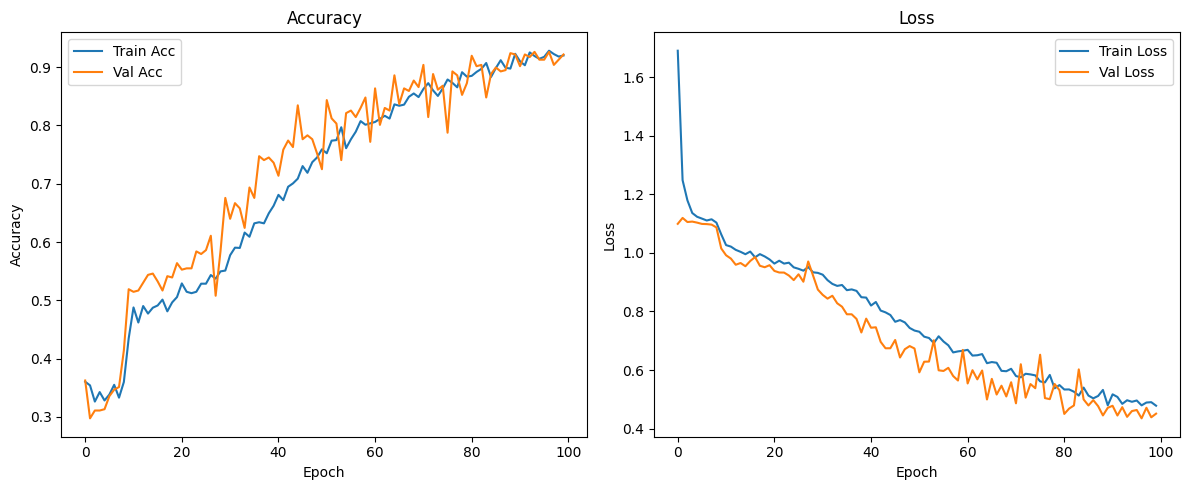

[Saved] /content/outputs/training_curves.png
TEST → Loss 0.4513 | Acc 0.9174 | F1 0.9173


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


[Saved] /content/outputs/gradcam_0_OAS1_0021_MR1_mpr-1_142.png


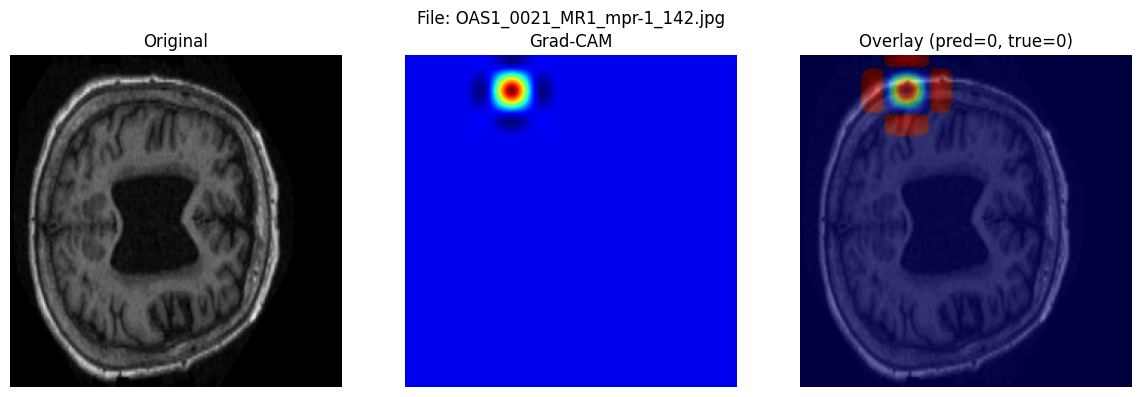

[Saved] /content/outputs/gradcam_1_OAS1_0053_MR1_mpr-1_102.png


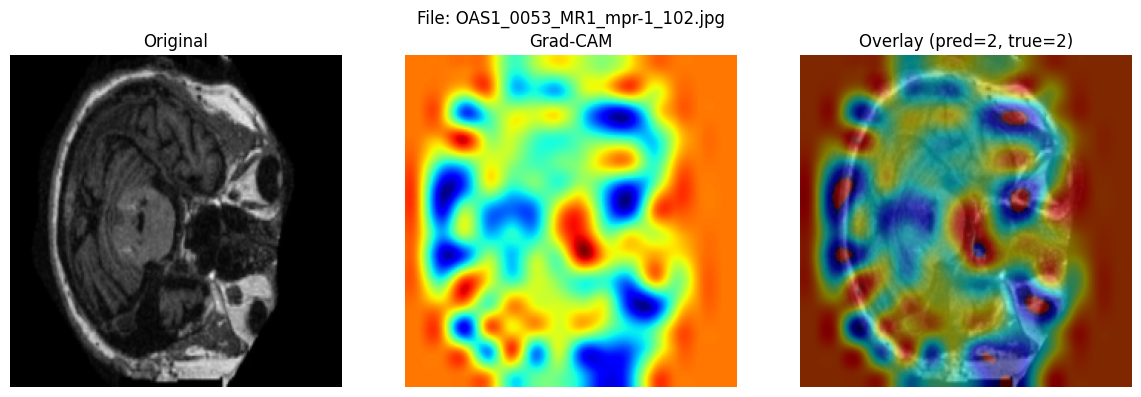

[Saved] /content/outputs/gradcam_2_OAS1_0001_MR1_mpr-2_138.png


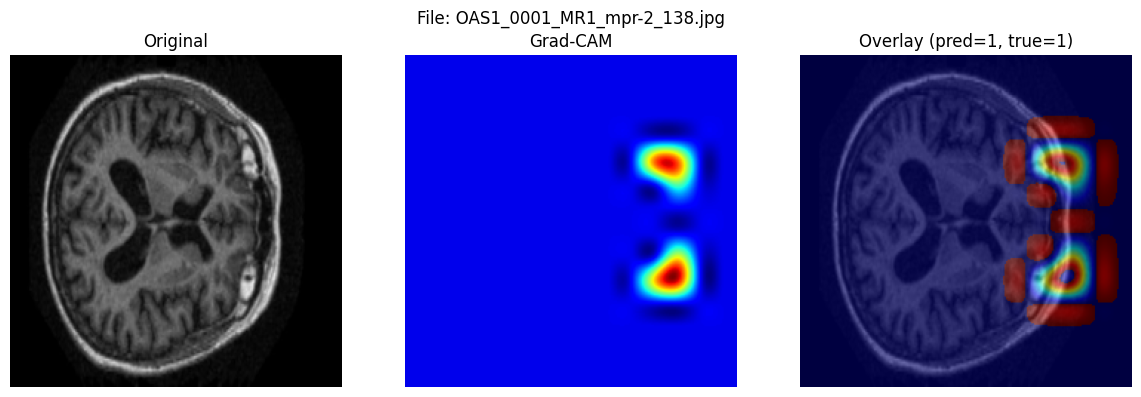

In [ ]:
# ================================
# Multimodal TransUNet + TabNet Top-K Fusion (No Early Stopping)
# ================================
# - Robust CSV ↔ image filename matching
# - Normalized class aliases
# - TransUNet encoder for images
# - TabNet (pytorch-tabnet) for tabular features selection (optional top-k CSV)
# - Concatenation fusion
# - Train for fixed epochs (no early stopping)
# - NEW: Plots of accuracy/loss after training
# - NEW: Grad-CAM on PatchEmbedding.proj conv layer

!pip install pytorch-tabnet -q

import os
import random
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
# Colab usually has cv2; this import should succeed
import cv2

# ----------------
# Config
# ----------------
class Cfg:
    data_root = "/content/dataset/Data/Data"
    tabular_csv = "/content/tabular_fixed.csv"
    topk_csv    = "/content/tabular_top10_features.csv"
    id_col = "ImageID"
    target_col = "Class"
    img_size = 224
    in_channels = 3
    batch_size = 16
    num_workers = 2
    seed = 42
    epochs = 100     # fixed training (no early stopping)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr_head = 1e-4
    lr_backbone = 1e-5
    weight_decay = 1e-4
    patch_size = 16
    embed_dim = 768
    num_heads = 8
    num_layers = 4
    freeze_backbone = True
    unfreeze_epoch = 5
    # outputs
    out_dir = "/content/outputs"

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)

def set_seed(s):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(cfg.seed)

# ----------------
# Normalize helpers
# ----------------
def normalize_ext_to_jpg(name: str) -> str:
    n = os.path.basename(name.strip().lower())
    n = n.replace(".jpg.png", ".jpg").replace(".png.jpg", ".jpg")
    root, ext = os.path.splitext(n)
    if ext in [".jpeg", ".png", ".jpg"]:
        n = root + ".jpg"
    return n

def stem_without_ext(name: str) -> str:
    return os.path.splitext(os.path.basename(name.strip().lower()))[0]

def class_alias(name: str) -> str:
    if name is None: return ""
    s = str(name).strip()
    if s.upper() in ["MCI", "MCI-1"]: return "MCI-1"
    if s.upper() == "AD": return "AD"
    if s.upper() == "CN": return "CN"
    return s

# ----------------
# Load Tabular (prefer top-k if present)
# ----------------
if os.path.exists(cfg.topk_csv):
    df_tab = pd.read_csv(cfg.topk_csv)
    print(f"[Info] Loaded top-k features {df_tab.shape}")
else:
    df_tab = pd.read_csv(cfg.tabular_csv)
    print(f"[Warn] Using full tabular {df_tab.shape}")

drop_cols = {cfg.id_col, cfg.target_col}
if "Sex" in df_tab.columns: drop_cols.add("Sex")
feature_cols = [c for c in df_tab.columns if c not in drop_cols]

tab_dict: Dict[str, Tuple[np.ndarray, str]] = {}
for _, row in df_tab.iterrows():
    raw_id = str(row[cfg.id_col])
    feats = row[feature_cols].to_numpy(dtype=np.float32)
    raw_cls = class_alias(row[cfg.target_col])
    keys = {normalize_ext_to_jpg(raw_id), stem_without_ext(raw_id)}
    for k in keys:
        tab_dict[k] = (feats, raw_cls)

print(f"[Info] Features: {len(feature_cols)}")

# ----------------
# Dataset
# ----------------
def to_three_channels(img_tensor: torch.Tensor) -> torch.Tensor:
    return img_tensor.repeat(3,1,1) if img_tensor.ndim==3 and img_tensor.size(0)==1 else img_tensor

transform_train = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
transform_eval = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class MultiModalDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, tab_dict, is_train=True):
        self.ifolder = image_folder
        self.tab_dict = tab_dict
        filtered_samples = []
        for path, y in self.ifolder.samples:
            base = os.path.basename(path)
            key = normalize_ext_to_jpg(base)
            key2 = stem_without_ext(base)
            row = tab_dict.get(key) or tab_dict.get(key2)
            if row:
                feats, csv_cls = row
                folder_cls = class_alias(self.ifolder.classes[y])
                if csv_cls == folder_cls:
                    filtered_samples.append((path, y))
        self.ifolder.samples = filtered_samples
        self.ifolder.targets = [s[1] for s in filtered_samples]

    def __len__(self): return len(self.ifolder)
    def __getitem__(self, idx):
        path, y = self.ifolder.samples[idx]
        img = self.ifolder.transform(Image.open(path).convert("RGB"))
        base = normalize_ext_to_jpg(os.path.basename(path))
        feats, _ = self.tab_dict.get(base) or self.tab_dict[stem_without_ext(base)]
        feats = torch.from_numpy(feats)
        return img, feats, y, Path(path).name

# ----------------
# Splits
# ----------------
base_folder = ImageFolder(cfg.data_root, transform=transform_train)
num_classes = len(base_folder.classes)
print(f"[Info] {len(base_folder)} images across {num_classes} classes: {base_folder.classes}")

# random split
all_idx = list(range(len(base_folder)))
random.shuffle(all_idx)
n = len(all_idx)
n_train, n_val = int(0.7*n), int(0.15*n)
train_idx, val_idx, test_idx = all_idx[:n_train], all_idx[n_train:n_train+n_val], all_idx[n_train+n_val:]

def subset(in_folder, idxs, transform):
    new = ImageFolder(in_folder.root, transform=transform)
    new.samples = [in_folder.samples[i] for i in idxs]
    new.targets = [s[1] for s in new.samples]
    new.classes = in_folder.classes
    new.class_to_idx = in_folder.class_to_idx
    return new

ds_train = MultiModalDataset(subset(base_folder, train_idx, transform_train), tab_dict, True)
ds_val   = MultiModalDataset(subset(base_folder, val_idx, transform_eval), tab_dict, False)
ds_test  = MultiModalDataset(subset(base_folder, test_idx, transform_eval), tab_dict, False)

def ensure_nonempty(ds, name):
    if len(ds) == 0:
        raise RuntimeError(f"{name} dataset is empty after matching. Check ID/class normalization.")
ensure_nonempty(ds_train, "Train")
ensure_nonempty(ds_val, "Val")
ensure_nonempty(ds_test, "Test")

train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
val_loader   = DataLoader(ds_val,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader  = DataLoader(ds_test,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

# ----------------
# Models
# ----------------
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, patch_size, patch_size)
        num_patches = (img_size//patch_size)**2
        self.cls = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos = nn.Parameter(torch.zeros(1,num_patches+1,embed_dim))
        self.drop = nn.Dropout(0.1)
    def forward(self,x):
        x = self.proj(x).flatten(2).transpose(1,2)   # B, N, E
        cls = self.cls.expand(x.size(0),-1,-1)       # B, 1, E
        x = torch.cat([cls,x],1) + self.pos          # B, N+1, E
        return self.drop(x)

class TransUNetEncoder(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers):
        super().__init__()
        self.patch = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        enc_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, embed_dim*4, 0.1, batch_first=False)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self,x):
        x = self.patch(x).permute(1,0,2)    # S, B, E
        x = self.encoder(x)                 # S, B, E
        cls = x[0]                          # B, E (CLS token)
        return self.norm(cls)

class FusionHead(nn.Module):
    def __init__(self,img_dim,tab_dim,num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim+tab_dim,64),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(64,32),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(32,num_classes)
        )
    def forward(self,img_feat,tab_feat): return self.net(torch.cat([img_feat,tab_feat],1))

img_encoder = TransUNetEncoder(cfg.img_size,cfg.patch_size,cfg.in_channels,cfg.embed_dim,cfg.num_heads,cfg.num_layers).to(cfg.device)
fusion_head = FusionHead(cfg.embed_dim,len(feature_cols),num_classes).to(cfg.device)

# freeze/unfreeze
for p in img_encoder.parameters(): p.requires_grad = not cfg.freeze_backbone
optimizer = optim.AdamW([
    {"params": fusion_head.parameters(), "lr": cfg.lr_head},
    {"params": [p for p in img_encoder.parameters() if p.requires_grad], "lr": cfg.lr_backbone}
], weight_decay=cfg.weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ----------------
# Train / Eval helpers
# ----------------
def run_epoch(loader,train):
    img_encoder.train(train); fusion_head.train(train)
    total_loss,preds,labels=0,[],[]
    for imgs,tabs,ys,_ in loader:
        imgs,tabs,ys = imgs.to(cfg.device), tabs.to(cfg.device).float(), ys.to(cfg.device)
        with torch.set_grad_enabled(train):
            feats = img_encoder(imgs)
            out = fusion_head(feats,tabs)
            loss = criterion(out,ys)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        preds.extend(out.argmax(1).detach().cpu().numpy()); labels.extend(ys.detach().cpu().numpy())
    return total_loss/len(loader.dataset), accuracy_score(labels,preds), f1_score(labels,preds,average="macro")

# ----------------
# Training loop (no early stopping) + HISTORY
# ----------------
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

for epoch in range(cfg.epochs):
    if cfg.freeze_backbone and epoch==cfg.unfreeze_epoch:
        for p in img_encoder.parameters(): p.requires_grad=True
        optimizer = optim.AdamW(list(img_encoder.parameters())+list(fusion_head.parameters()),
                                lr=cfg.lr_backbone, weight_decay=cfg.weight_decay)
        print(f"[Info] Unfrozen backbone at epoch {epoch}")

    tr_loss,tr_acc,tr_f1 = run_epoch(train_loader,True)
    va_loss,va_acc,va_f1 = run_epoch(val_loader,False)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | "
          f"Train {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || "
          f"Val {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")

# ----------------
# Plot accuracy/loss curves
# ----------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")

plt.tight_layout()
plot_path = os.path.join(cfg.out_dir, "training_curves.png")
plt.savefig(plot_path, dpi=150)
plt.show()
print(f"[Saved] {plot_path}")

# ----------------
# Test
# ----------------
te_loss,te_acc,te_f1 = run_epoch(test_loader,False)
print(f"TEST → Loss {te_loss:.4f} | Acc {te_acc:.4f} | F1 {te_f1:.4f}")

# ----------------
# Grad-CAM on PatchEmbedding.proj
# ----------------
class GradCAM:
    """
    Grad-CAM on the first conv (PatchEmbedding.proj).
    Produces CAM in image space (resized to cfg.img_size x cfg.img_size).
    """
    def __init__(self, encoder_model, fusion_model, target_layer):
        self.encoder = encoder_model
        self.fusion = fusion_model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # forward hook to cache activations
        def fwd_hook(module, inp, out):
            self.activations = out.detach()  # shape: (B, C, H', W')
        # backward hook to cache grads wrt activations
        def bwd_hook(module, grad_in, grad_out):
            # grad_out[0] is dL/d(activations)
            self.gradients = grad_out[0].detach()

        target_layer.register_forward_hook(fwd_hook)
        # use full backward hook for newer PyTorch
        target_layer.register_full_backward_hook(bwd_hook)

    @torch.no_grad()
    def _denorm(self, img_tensor: torch.Tensor) -> np.ndarray:
        # img_tensor: (3,H,W) normalized with mean=std=0.5
        x = img_tensor.clone().cpu()
        x = x * 0.5 + 0.5  # back to [0,1]
        x = x.permute(1,2,0).numpy()
        x = np.clip(x, 0, 1)
        return x

    def __call__(self, img_tensor, tab_feats, class_idx=None):
        """
        img_tensor: (3,H,W) single image (already transformed)
        tab_feats:  (F,)   corresponding tabular features
        """
        self.encoder.zero_grad(set_to_none=True)
        self.fusion.zero_grad(set_to_none=True)

        img_b = img_tensor.unsqueeze(0).to(cfg.device)           # (1,3,H,W)
        tab_b = tab_feats.unsqueeze(0).float().to(cfg.device)    # (1,F)

        # forward
        feats = self.encoder(img_b)               # (1, E)
        logits = self.fusion(feats, tab_b)        # (1, C)

        if class_idx is None:
            class_idx = logits.argmax(1).item()

        # backward on selected class score
        score = logits[0, class_idx]
        score.backward(retain_graph=False)

        # activations: (1, C, H', W'), gradients: (1, C, H', W')
        acts = self.activations           # detach in hook
        grads = self.gradients            # detach in hook

        # global-average-pool the grads to get channel weights
        weights = grads.mean(dim=(2,3), keepdim=True)            # (1, C, 1, 1)
        cam = (weights * acts).sum(dim=1, keepdim=False)         # (1, H', W')
        cam = cam.squeeze(0).cpu().numpy()
        cam = np.maximum(cam, 0)  # ReLU

        # normalize and resize to input size
        if cam.max() > 0:
            cam = cam / cam.max()
        cam = cv2.resize(cam, (cfg.img_size, cfg.img_size), interpolation=cv2.INTER_CUBIC)

        # visuals
        img_np = self._denorm(img_tensor)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = 0.5 * img_np + 0.5 * heatmap
        overlay = np.clip(overlay, 0, 1)

        return img_np, cam, overlay, class_idx

# Instantiate Grad-CAM for the patch conv
target_layer = img_encoder.patch.proj
gradcam = GradCAM(img_encoder, fusion_head, target_layer)

# ----------------
# Visualize Grad-CAM on a few test samples
# ----------------
def show_and_save_gradcam(dataset, idx=0, save=True):
    img, feats, y, fname = dataset[idx]  # img already normalized tensor
    img_np, cam, overlay, pred_idx = gradcam(img, feats, class_idx=None)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay (pred={pred_idx}, true={y})"); plt.axis("off")
    plt.suptitle(f"File: {fname}")
    plt.tight_layout()
    if save:
        out_path = os.path.join(cfg.out_dir, f"gradcam_{idx}_{Path(fname).stem}.png")
        plt.savefig(out_path, dpi=150)
        print(f"[Saved] {out_path}")
    plt.show()

# Example: visualize first 3 test samples (adjust count as you like)
num_to_show = min(3, len(ds_test))
for i in range(num_to_show):
    show_and_save_gradcam(ds_test, i, save=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00
[Warn] Using full tabular (2982, 9)
[Info] Features: 6
[Info] 2982 images across 3 classes: ['AD', 'CN', 'MCI-1']


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01/100 | Train 1.5982 acc 0.3440 f1 0.3383 || Val 1.1439 acc 0.3423 f1 0.1745
Epoch 02/100 | Train 1.2011 acc 0.3493 f1 0.3372 || Val 1.1177 acc 0.3020 f1 0.2093
Epoch 03/100 | Train 1.1544 acc 0.3522 f1 0.3387 || Val 1.1087 acc 0.2864 f1 0.2069
Epoch 04/100 | Train 1.1370 acc 0.3503 f1 0.3319 || Val 1.1017 acc 0.3356 f1 0.1678
Epoch 05/100 | Train 1.1157 acc 0.3531 f1 0.3203 || Val 1.1002 acc 0.3423 f1 0.1700
[Info] Unfrozen ViT backbone at epoch 5
Epoch 06/100 | Train 1.1165 acc 0.3512 f1 0.3179 || Val 1.0977 acc 0.3423 f1 0.1700
Epoch 07/100 | Train 1.1120 acc 0.3536 f1 0.3131 || Val 1.0985 acc 0.3423 f1 0.1700
Epoch 08/100 | Train 1.1089 acc 0.3761 f1 0.3365 || Val 1.0959 acc 0.3624 f1 0.2041
Epoch 09/100 | Train 1.0857 acc 0.4169 f1 0.3861 || Val 1.0491 acc 0.4609 f1 0.3835
Epoch 10/100 | Train 1.0414 acc 0.4566 f1 0.4454 || Val 1.0021 acc 0.5302 f1 0.4255
Epoch 11/100 | Train 1.0395 acc 0.4667 f1 0.4523 || Val 1.0204 acc 0.4676 f1 0.4516
Epoch 12/100 | Train 1.0136 acc 0.48

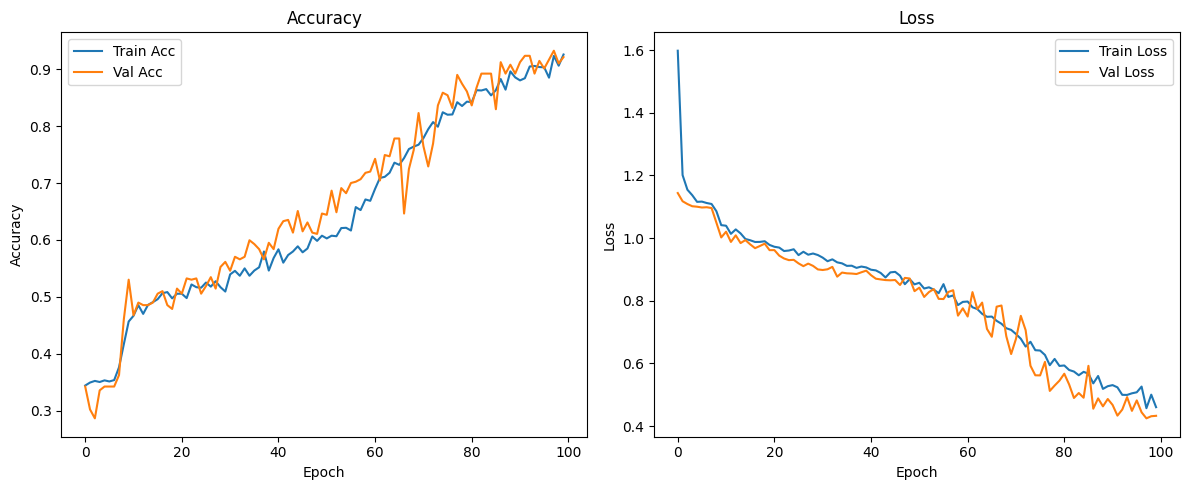

[Saved] /content/outputs/training_curves.png
TEST → Loss 0.4457 | Acc 0.9085 | F1 0.9077


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


[Saved] /content/outputs/gradcam_0_OAS1_0021_MR1_mpr-1_142.png


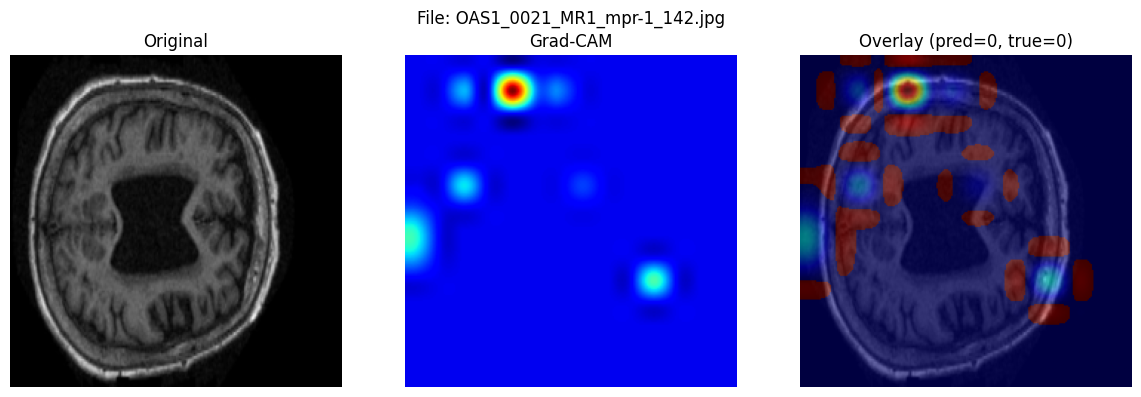

[Saved] /content/outputs/gradcam_1_OAS1_0053_MR1_mpr-1_102.png


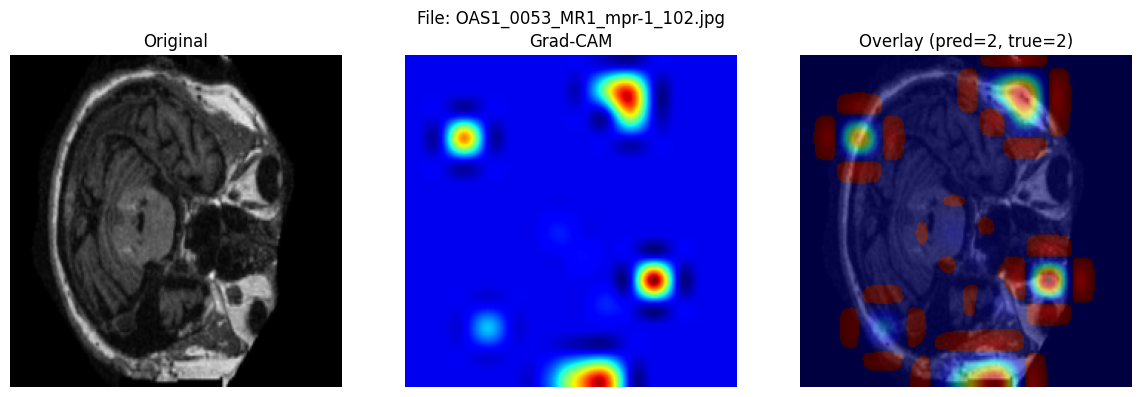

[Saved] /content/outputs/gradcam_2_OAS1_0001_MR1_mpr-2_138.png


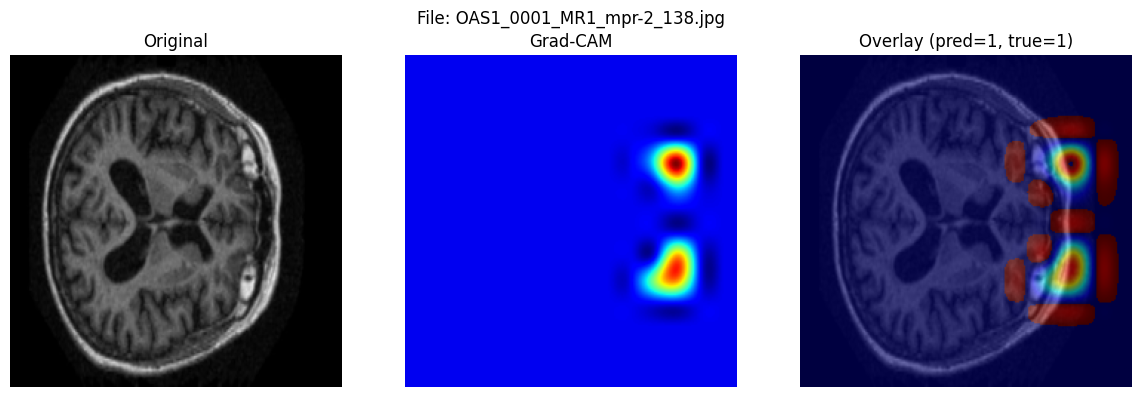

In [ ]:
# ================================
# Multimodal ViT + TabNet Top-K Fusion (No Early Stopping)
# ================================
# - Robust CSV ↔ image filename matching
# - Normalized class aliases
# - ViT encoder for images (CLS embedding)
# - TabNet (optional top-k CSV)
# - Concatenation fusion
# - Plots accuracy/loss after training
# - Grad-CAM on ViT PatchEmbedding.proj
# ================================

!pip install pytorch-tabnet -q

import os
import random
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import cv2

# ----------------
# Config
# ----------------
class Cfg:
    data_root = "/content/dataset/Data/Data"
    tabular_csv = "/content/tabular_fixed.csv"
    topk_csv    = "/content/tabular_top10_features.csv"
    id_col = "ImageID"
    target_col = "Class"
    img_size = 224
    in_channels = 3
    batch_size = 16
    num_workers = 2
    seed = 42
    epochs = 100     # fixed training
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr_head = 1e-4
    lr_backbone = 1e-5
    weight_decay = 1e-4
    patch_size = 16
    embed_dim = 768
    num_heads = 8
    num_layers = 4
    freeze_backbone = True
    unfreeze_epoch = 5
    out_dir = "/content/outputs"

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)

def set_seed(s):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(cfg.seed)

# ----------------
# Normalize helpers
# ----------------
def normalize_ext_to_jpg(name: str) -> str:
    n = os.path.basename(name.strip().lower())
    n = n.replace(".jpg.png", ".jpg").replace(".png.jpg", ".jpg")
    root, ext = os.path.splitext(n)
    if ext in [".jpeg", ".png", ".jpg"]: n = root + ".jpg"
    return n

def stem_without_ext(name: str) -> str:
    return os.path.splitext(os.path.basename(name.strip().lower()))[0]

def class_alias(name: str) -> str:
    if name is None: return ""
    s = str(name).strip()
    if s.upper() in ["MCI", "MCI-1"]: return "MCI-1"
    if s.upper() == "AD": return "AD"
    if s.upper() == "CN": return "CN"
    return s

# ----------------
# Load Tabular (prefer top-k if present)
# ----------------
if os.path.exists(cfg.topk_csv):
    df_tab = pd.read_csv(cfg.topk_csv)
    print(f"[Info] Loaded top-k features {df_tab.shape}")
else:
    df_tab = pd.read_csv(cfg.tabular_csv)
    print(f"[Warn] Using full tabular {df_tab.shape}")

drop_cols = {cfg.id_col, cfg.target_col}
if "Sex" in df_tab.columns: drop_cols.add("Sex")
feature_cols = [c for c in df_tab.columns if c not in drop_cols]

tab_dict: Dict[str, Tuple[np.ndarray, str]] = {}
for _, row in df_tab.iterrows():
    raw_id = str(row[cfg.id_col])
    feats = row[feature_cols].to_numpy(dtype=np.float32)
    raw_cls = class_alias(row[cfg.target_col])
    keys = {normalize_ext_to_jpg(raw_id), stem_without_ext(raw_id)}
    for k in keys:
        tab_dict[k] = (feats, raw_cls)

print(f"[Info] Features: {len(feature_cols)}")

# ----------------
# Dataset
# ----------------
def to_three_channels(img_tensor: torch.Tensor) -> torch.Tensor:
    return img_tensor.repeat(3,1,1) if img_tensor.ndim==3 and img_tensor.size(0)==1 else img_tensor

transform_train = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
transform_eval = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class MultiModalDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, tab_dict, is_train=True):
        self.ifolder = image_folder
        self.tab_dict = tab_dict
        filtered_samples = []
        for path, y in self.ifolder.samples:
            base = os.path.basename(path)
            key = normalize_ext_to_jpg(base)
            key2 = stem_without_ext(base)
            row = tab_dict.get(key) or tab_dict.get(key2)
            if row:
                feats, csv_cls = row
                folder_cls = class_alias(self.ifolder.classes[y])
                if csv_cls == folder_cls:
                    filtered_samples.append((path, y))
        self.ifolder.samples = filtered_samples
        self.ifolder.targets = [s[1] for s in filtered_samples]

    def __len__(self): return len(self.ifolder)
    def __getitem__(self, idx):
        path, y = self.ifolder.samples[idx]
        img = self.ifolder.transform(Image.open(path).convert("RGB"))
        base = normalize_ext_to_jpg(os.path.basename(path))
        feats, _ = self.tab_dict.get(base) or self.tab_dict[stem_without_ext(base)]
        feats = torch.from_numpy(feats)
        return img, feats, y, Path(path).name

# ----------------
# Splits
# ----------------
base_folder = ImageFolder(cfg.data_root, transform=transform_train)
num_classes = len(base_folder.classes)
print(f"[Info] {len(base_folder)} images across {num_classes} classes: {base_folder.classes}")

all_idx = list(range(len(base_folder)))
random.shuffle(all_idx)
n = len(all_idx)
n_train, n_val = int(0.7*n), int(0.15*n)
train_idx, val_idx, test_idx = all_idx[:n_train], all_idx[n_train:n_train+n_val], all_idx[n_train+n_val:]

def subset(in_folder, idxs, transform):
    new = ImageFolder(in_folder.root, transform=transform)
    new.samples = [in_folder.samples[i] for i in idxs]
    new.targets = [s[1] for s in new.samples]
    new.classes = in_folder.classes
    new.class_to_idx = in_folder.class_to_idx
    return new

ds_train = MultiModalDataset(subset(base_folder, train_idx, transform_train), tab_dict, True)
ds_val   = MultiModalDataset(subset(base_folder, val_idx, transform_eval), tab_dict, False)
ds_test  = MultiModalDataset(subset(base_folder, test_idx, transform_eval), tab_dict, False)

def ensure_nonempty(ds, name):
    if len(ds) == 0:
        raise RuntimeError(f"{name} dataset is empty after matching. Check ID/class normalization.")
ensure_nonempty(ds_train, "Train")
ensure_nonempty(ds_val, "Val")
ensure_nonempty(ds_test, "Test")

train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
val_loader   = DataLoader(ds_val,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader  = DataLoader(ds_test,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

# ----------------
# ViT Encoder
# ----------------
class ViTPatchEmbedding(nn.Module):
    """
    Patch embedding with conv (kernel=stride=patch_size).
    Produces tokens + learnable CLS token + positional embeddings.
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, drop=0.1):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, patch_size, patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.drop = nn.Dropout(drop)

    def forward(self, x):                   # x: (B,3,H,W)
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B, N, E)
        cls = self.cls.expand(x.size(0), -1, -1)     # (B,1,E)
        x = torch.cat([cls, x], dim=1) + self.pos    # (B, N+1, E)
        return self.drop(x)

class ViTEncoder(nn.Module):
    """
    Minimal ViT encoder; returns normalized CLS embedding (B, E).
    """
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, drop=0.1):
        super().__init__()
        self.patch = ViTPatchEmbedding(img_size, patch_size, in_channels, embed_dim, drop)
        enc_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                               dim_feedforward=embed_dim*4, dropout=drop,
                                               batch_first=False)  # we permute to (S,B,E)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch(x)            # (B, N+1, E)
        x = x.permute(1, 0, 2)       # (S, B, E)
        x = self.encoder(x)          # (S, B, E)
        cls = x[0]                   # (B, E)
        return self.norm(cls)

# ----------------
# Fusion Head (image CLS + tabular features)
# ----------------
class FusionHead(nn.Module):
    def __init__(self, img_dim, tab_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim + tab_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    def forward(self, img_feat, tab_feat):
        return self.net(torch.cat([img_feat, tab_feat], dim=1))

vit_encoder = ViTEncoder(cfg.img_size, cfg.patch_size, cfg.in_channels,
                         cfg.embed_dim, cfg.num_heads, cfg.num_layers).to(cfg.device)
fusion_head = FusionHead(cfg.embed_dim, len(feature_cols), num_classes).to(cfg.device)

# freeze/unfreeze
for p in vit_encoder.parameters(): p.requires_grad = not cfg.freeze_backbone
optimizer = optim.AdamW([
    {"params": fusion_head.parameters(), "lr": cfg.lr_head},
    {"params": [p for p in vit_encoder.parameters() if p.requires_grad], "lr": cfg.lr_backbone},
], weight_decay=cfg.weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ----------------
# Train / Eval helpers
# ----------------
def run_epoch(loader, train):
    vit_encoder.train(train); fusion_head.train(train)
    total_loss, preds, labels = 0.0, [], []
    for imgs, tabs, ys, _ in loader:
        imgs, tabs, ys = imgs.to(cfg.device), tabs.to(cfg.device).float(), ys.to(cfg.device)
        with torch.set_grad_enabled(train):
            img_feats = vit_encoder(imgs)
            logits = fusion_head(img_feats, tabs)
            loss = criterion(logits, ys)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds.extend(logits.argmax(1).detach().cpu().numpy())
        labels.extend(ys.detach().cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(labels, preds), f1_score(labels, preds, average="macro")

# ----------------
# Training loop (no early stopping) + history
# ----------------
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

for epoch in range(cfg.epochs):
    if cfg.freeze_backbone and epoch == cfg.unfreeze_epoch:
        for p in vit_encoder.parameters(): p.requires_grad = True
        optimizer = optim.AdamW(list(vit_encoder.parameters()) + list(fusion_head.parameters()),
                                lr=cfg.lr_backbone, weight_decay=cfg.weight_decay)
        print(f"[Info] Unfrozen ViT backbone at epoch {epoch}")

    tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, True)
    va_loss, va_acc, va_f1 = run_epoch(val_loader, False)

    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)

    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | "
          f"Train {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || "
          f"Val {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")

# ----------------
# Plot accuracy/loss curves
# ----------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")

plt.tight_layout()
plot_path = os.path.join(cfg.out_dir, "training_curves.png")
plt.savefig(plot_path, dpi=150)
plt.show()
print(f"[Saved] {plot_path}")

# ----------------
# Test
# ----------------
te_loss, te_acc, te_f1 = run_epoch(test_loader, False)
print(f"TEST → Loss {te_loss:.4f} | Acc {te_acc:.4f} | F1 {te_f1:.4f}")

# ----------------
# Grad-CAM on ViT PatchEmbedding.proj
# ----------------
class GradCAM:
    """
    Grad-CAM over the ViT patch embedding conv (kernel=stride=patch).
    """
    def __init__(self, encoder_model, fusion_model, target_layer):
        self.encoder = encoder_model
        self.fusion = fusion_model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def fwd_hook(module, inp, out):
            self.activations = out.detach()            # (B, C, H', W')
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()      # (B, C, H', W')

        target_layer.register_forward_hook(fwd_hook)
        target_layer.register_full_backward_hook(bwd_hook)

    @torch.no_grad()
    def _denorm(self, img_tensor):
        x = img_tensor.clone().cpu()
        x = x * 0.5 + 0.5
        x = x.permute(1,2,0).numpy()
        return np.clip(x, 0, 1)

    def __call__(self, img_tensor, tab_feats, class_idx=None):
        self.encoder.zero_grad(set_to_none=True)
        self.fusion.zero_grad(set_to_none=True)

        img_b = img_tensor.unsqueeze(0).to(cfg.device)
        tab_b = tab_feats.unsqueeze(0).float().to(cfg.device)

        feats = self.encoder(img_b)                  # (1,E)
        logits = self.fusion(feats, tab_b)           # (1,C)
        if class_idx is None:
            class_idx = logits.argmax(1).item()

        score = logits[0, class_idx]
        score.backward()

        acts = self.activations
        grads = self.gradients
        weights = grads.mean(dim=(2,3), keepdim=True)     # (1,C,1,1)
        cam = (weights * acts).sum(dim=1, keepdim=False)  # (1,H',W')
        cam = cam.squeeze(0).cpu().numpy()
        cam = np.maximum(cam, 0)
        if cam.max() > 0:
            cam = cam / cam.max()
        cam = cv2.resize(cam, (cfg.img_size, cfg.img_size), interpolation=cv2.INTER_CUBIC)

        img_np = self._denorm(img_tensor)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
        return img_np, cam, overlay, class_idx

# Instantiate Grad-CAM on ViT patch conv
target_layer = vit_encoder.patch.proj
gradcam = GradCAM(vit_encoder, fusion_head, target_layer)

# ----------------
# Visualize Grad-CAM on a few test samples
# ----------------
def show_and_save_gradcam(dataset, idx=0, save=True):
    img, feats, y, fname = dataset[idx]
    img_np, cam, overlay, pred_idx = gradcam(img, feats, class_idx=None)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay (pred={pred_idx}, true={y})"); plt.axis("off")
    plt.suptitle(f"File: {fname}")
    plt.tight_layout()
    if save:
        out_path = os.path.join(cfg.out_dir, f"gradcam_{idx}_{Path(fname).stem}.png")
        plt.savefig(out_path, dpi=150)
        print(f"[Saved] {out_path}")
    plt.show()

# Example: visualize first 3 test samples
num_to_show = min(3, len(ds_test))
for i in range(num_to_show):
    show_and_save_gradcam(ds_test, i, save=True)


In [ ]:
# ================================
# Multimodal ViT + TabNet Cross-Attention Fusion
# ================================
# - Robust CSV ↔ image filename matching
# - Normalized class aliases
# - ViT encoder for images (CLS embedding)
# - Tabular features projected + cross-attention fusion
# - Plots accuracy/loss after training
# - Grad-CAM on ViT PatchEmbedding.proj
# ================================

!pip install pytorch-tabnet -q

import os
import random
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import cv2

# ----------------
# Config
# ----------------
class Cfg:
    data_root = "/content/dataset/Data/Data"
    tabular_csv = "/content/tabular_fixed.csv"
    topk_csv    = "/content/tabular_top10_features.csv"
    id_col = "ImageID"
    target_col = "Class"
    img_size = 224
    in_channels = 3
    batch_size = 16
    num_workers = 2
    seed = 42
    epochs = 100     # fixed training
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr_head = 1e-4
    lr_backbone = 1e-5
    weight_decay = 1e-4
    patch_size = 16
    embed_dim = 768
    num_heads = 8
    num_layers = 4
    freeze_backbone = True
    unfreeze_epoch = 5
    out_dir = "/content/outputs"

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)

def set_seed(s):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(cfg.seed)

# ----------------
# Normalize helpers
# ----------------
def normalize_ext_to_jpg(name: str) -> str:
    n = os.path.basename(name.strip().lower())
    n = n.replace(".jpg.png", ".jpg").replace(".png.jpg", ".jpg")
    root, ext = os.path.splitext(n)
    if ext in [".jpeg", ".png", ".jpg"]: n = root + ".jpg"
    return n

def stem_without_ext(name: str) -> str:
    return os.path.splitext(os.path.basename(name.strip().lower()))[0]

def class_alias(name: str) -> str:
    if name is None: return ""
    s = str(name).strip()
    if s.upper() in ["MCI", "MCI-1"]: return "MCI-1"
    if s.upper() == "AD": return "AD"
    if s.upper() == "CN": return "CN"
    return s

# ----------------
# Load Tabular (prefer top-k if present)
# ----------------
if os.path.exists(cfg.topk_csv):
    df_tab = pd.read_csv(cfg.topk_csv)
    print(f"[Info] Loaded top-k features {df_tab.shape}")
else:
    df_tab = pd.read_csv(cfg.tabular_csv)
    print(f"[Warn] Using full tabular {df_tab.shape}")

drop_cols = {cfg.id_col, cfg.target_col}
if "Sex" in df_tab.columns: drop_cols.add("Sex")
feature_cols = [c for c in df_tab.columns if c not in drop_cols]

tab_dict: Dict[str, Tuple[np.ndarray, str]] = {}
for _, row in df_tab.iterrows():
    raw_id = str(row[cfg.id_col])
    feats = row[feature_cols].to_numpy(dtype=np.float32)
    raw_cls = class_alias(row[cfg.target_col])
    keys = {normalize_ext_to_jpg(raw_id), stem_without_ext(raw_id)}
    for k in keys:
        tab_dict[k] = (feats, raw_cls)

print(f"[Info] Features: {len(feature_cols)}")

# ----------------
# Dataset
# ----------------
def to_three_channels(img_tensor: torch.Tensor) -> torch.Tensor:
    return img_tensor.repeat(3,1,1) if img_tensor.ndim==3 and img_tensor.size(0)==1 else img_tensor

transform_train = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
transform_eval = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Lambda(to_three_channels),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class MultiModalDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, tab_dict, is_train=True):
        self.ifolder = image_folder
        self.tab_dict = tab_dict
        filtered_samples = []
        for path, y in self.ifolder.samples:
            base = os.path.basename(path)
            key = normalize_ext_to_jpg(base)
            key2 = stem_without_ext(base)
            row = tab_dict.get(key) or tab_dict.get(key2)
            if row:
                feats, csv_cls = row
                folder_cls = class_alias(self.ifolder.classes[y])
                if csv_cls == folder_cls:
                    filtered_samples.append((path, y))
        self.ifolder.samples = filtered_samples
        self.ifolder.targets = [s[1] for s in filtered_samples]

    def __len__(self): return len(self.ifolder)
    def __getitem__(self, idx):
        path, y = self.ifolder.samples[idx]
        img = self.ifolder.transform(Image.open(path).convert("RGB"))
        base = normalize_ext_to_jpg(os.path.basename(path))
        feats, _ = self.tab_dict.get(base) or self.tab_dict[stem_without_ext(base)]
        feats = torch.from_numpy(feats)
        return img, feats, y, Path(path).name

# ----------------
# Splits
# ----------------
base_folder = ImageFolder(cfg.data_root, transform=transform_train)
num_classes = len(base_folder.classes)
print(f"[Info] {len(base_folder)} images across {num_classes} classes: {base_folder.classes}")

all_idx = list(range(len(base_folder)))
random.shuffle(all_idx)
n = len(all_idx)
n_train, n_val = int(0.7*n), int(0.15*n)
train_idx, val_idx, test_idx = all_idx[:n_train], all_idx[n_train:n_train+n_val], all_idx[n_train+n_val:]

def subset(in_folder, idxs, transform):
    new = ImageFolder(in_folder.root, transform=transform)
    new.samples = [in_folder.samples[i] for i in idxs]
    new.targets = [s[1] for s in new.samples]
    new.classes = in_folder.classes
    new.class_to_idx = in_folder.class_to_idx
    return new

ds_train = MultiModalDataset(subset(base_folder, train_idx, transform_train), tab_dict, True)
ds_val   = MultiModalDataset(subset(base_folder, val_idx, transform_eval), tab_dict, False)
ds_test  = MultiModalDataset(subset(base_folder, test_idx, transform_eval), tab_dict, False)

def ensure_nonempty(ds, name):
    if len(ds) == 0:
        raise RuntimeError(f"{name} dataset is empty after matching. Check ID/class normalization.")
ensure_nonempty(ds_train, "Train")
ensure_nonempty(ds_val, "Val")
ensure_nonempty(ds_test, "Test")

train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
val_loader   = DataLoader(ds_val,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader  = DataLoader(ds_test,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

# ----------------
# ViT Encoder
# ----------------
class ViTPatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, drop=0.1):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, patch_size, patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls = self.cls.expand(x.size(0), -1, -1)
        x = torch.cat([cls, x], dim=1) + self.pos
        return self.drop(x)

class ViTEncoder(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, drop=0.1):
        super().__init__()
        self.patch = ViTPatchEmbedding(img_size, patch_size, in_channels, embed_dim, drop)
        enc_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                               dim_feedforward=embed_dim*4, dropout=drop,
                                               batch_first=False)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch(x)
        x = x.permute(1, 0, 2)
        x = self.encoder(x)
        cls = x[0]
        return self.norm(cls)

# ----------------
# Cross-Attention Fusion Head
# ----------------
class CrossAttentionFusion(nn.Module):
    def __init__(self, img_dim, tab_dim, num_classes, num_heads=4):
        super().__init__()
        self.tab_proj = nn.Linear(tab_dim, img_dim)
        self.attn = nn.MultiheadAttention(embed_dim=img_dim, num_heads=num_heads, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(img_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, img_feat, tab_feat):
        # img_feat: (B, E)
        # tab_feat: (B, F)
        q = img_feat.unsqueeze(1)               # (B,1,E)
        kv = self.tab_proj(tab_feat).unsqueeze(1)  # (B,1,E)
        attn_out, _ = self.attn(q, kv, kv)      # (B,1,E)
        fused = attn_out.squeeze(1)             # (B,E)
        return self.mlp(fused)

vit_encoder = ViTEncoder(cfg.img_size, cfg.patch_size, cfg.in_channels,
                         cfg.embed_dim, cfg.num_heads, cfg.num_layers).to(cfg.device)
fusion_head = CrossAttentionFusion(cfg.embed_dim, len(feature_cols), num_classes).to(cfg.device)

# freeze/unfreeze
for p in vit_encoder.parameters(): p.requires_grad = not cfg.freeze_backbone
optimizer = optim.AdamW([
    {"params": fusion_head.parameters(), "lr": cfg.lr_head},
    {"params": [p for p in vit_encoder.parameters() if p.requires_grad], "lr": cfg.lr_backbone},
], weight_decay=cfg.weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ----------------
# Train / Eval helpers
# ----------------
def run_epoch(loader, train):
    vit_encoder.train(train); fusion_head.train(train)
    total_loss, preds, labels = 0.0, [], []
    for imgs, tabs, ys, _ in loader:
        imgs, tabs, ys = imgs.to(cfg.device), tabs.to(cfg.device).float(), ys.to(cfg.device)
        with torch.set_grad_enabled(train):
            img_feats = vit_encoder(imgs)
            logits = fusion_head(img_feats, tabs)
            loss = criterion(logits, ys)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds.extend(logits.argmax(1).detach().cpu().numpy())
        labels.extend(ys.detach().cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(labels, preds), f1_score(labels, preds, average="macro")

# ----------------
# Training loop (no early stopping) + history
# ----------------
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

for epoch in range(cfg.epochs):
    if cfg.freeze_backbone and epoch == cfg.unfreeze_epoch:
        for p in vit_encoder.parameters(): p.requires_grad = True
        optimizer = optim.AdamW(list(vit_encoder.parameters()) + list(fusion_head.parameters()),
                                lr=cfg.lr_backbone, weight_decay=cfg.weight_decay)
        print(f"[Info] Unfrozen ViT backbone at epoch {epoch}")

    tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, True)
    va_loss, va_acc, va_f1 = run_epoch(val_loader, False)

    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)

    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | "
          f"Train {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || "
          f"Val {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")

# ----------------
# Plot accuracy/loss curves
# ----------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")

plt.tight_layout()
plot_path = os.path.join(cfg.out_dir, "training_curves.png")
plt.savefig(plot_path, dpi=150)
plt.show()
print(f"[Saved] {plot_path}")

# ----------------
# Test
# ----------------
te_loss, te_acc, te_f1 = run_epoch(test_loader, False)
print(f"TEST → Loss {te_loss:.4f} | Acc {te_acc:.4f} | F1 {te_f1:.4f}")

# ----------------
# Grad-CAM on ViT PatchEmbedding.proj
# ----------------
class GradCAM:
    def __init__(self, encoder_model, fusion_model, target_layer):
        self.encoder = encoder_model
        self.fusion = fusion_model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def fwd_hook(module, inp, out):
            self.activations = out.detach()
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer.register_forward_hook(fwd_hook)
        target_layer.register_full_backward_hook(bwd_hook)

    @torch.no_grad()
    def _denorm(self, img_tensor):
        x = img_tensor.clone().cpu()
        x = x * 0.5 + 0.5
        x = x.permute(1,2,0).numpy()
        return np.clip(x, 0, 1)

    def __call__(self, img_tensor, tab_feats, class_idx=None):
        self.encoder.zero_grad(set_to_none=True)
        self.fusion.zero_grad(set_to_none=True)

        img_b = img_tensor.unsqueeze(0).to(cfg.device)
        tab_b = tab_feats.unsqueeze(0).float().to(cfg.device)

        feats = self.encoder(img_b)
        logits = self.fusion(feats, tab_b)
        if class_idx is None:
            class_idx = logits.argmax(1).item()

        score = logits[0, class_idx]
        score.backward()

        acts = self.activations
        grads = self.gradients
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=False)
        cam = cam.squeeze(0).cpu().numpy()
        cam = np.maximum(cam, 0)
        if cam.max() > 0:
            cam = cam / cam.max()
        cam = cv2.resize(cam, (cfg.img_size, cfg.img_size), interpolation=cv2.INTER_CUBIC)

        img_np = self._denorm(img_tensor)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
        return img_np, cam, overlay, class_idx

target_layer = vit_encoder.patch.proj
gradcam = GradCAM(vit_encoder, fusion_head, target_layer)

def show_and_save_gradcam(dataset, idx=0, save=True):
    img, feats, y, fname = dataset[idx]
    img_np, cam, overlay, pred_idx = gradcam(img, feats, class_idx=None)

    plt.figure(figsize=(12,4))
    plt


In [ ]:
# ================================
# Multimodal HuggingFace ViT + Tabular Cross-Attention Fusion (Processor-free)
# ================================
# - Uses pretrained HuggingFace ViT model (Koushim/vit-brain-mri-classifier)
# - Manual preprocessing (Resize/Normalize) because repo lacks preprocessor_config.json
# - Robust CSV ↔ image filename matching
# - Extracts CLS embedding from ViT backbone
# - Tabular features projected + cross-attention fusion
# - Plots accuracy/loss after training
# - Grad-CAM on HuggingFace ViT PatchEmbedding.proj
# ================================

# If running in Colab, uncomment the next line
# !pip install pytorch-tabnet transformers -q

import os
import random
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import cv2

from transformers import ViTForImageClassification

# ----------------
# Config
# ----------------
class Cfg:
    data_root = "/content/dataset/Data/Data"
    tabular_csv = "/content/tabular_fixed.csv"
    topk_csv    = "/content/tabular_top10_features.csv"
    id_col = "ImageID"
    target_col = "Class"
    img_size = 224
    batch_size = 16
    num_workers = 2
    seed = 42
    epochs = 100
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr_head = 1e-4
    lr_backbone = 1e-5
    weight_decay = 1e-4
    freeze_backbone = True
    unfreeze_epoch = 5
    out_dir = "/content/outputs"

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)

def set_seed(s):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(cfg.seed)

# ----------------
# Normalize helpers
# ----------------
def normalize_ext_to_jpg(name: str) -> str:
    n = os.path.basename(name.strip().lower())
    n = n.replace(".jpg.png", ".jpg").replace(".png.jpg", ".jpg")
    root, ext = os.path.splitext(n)
    if ext in [".jpeg", ".png", ".jpg"]: n = root + ".jpg"
    return n

def stem_without_ext(name: str) -> str:
    return os.path.splitext(os.path.basename(name.strip().lower()))[0]

def class_alias(name: str) -> str:
    if name is None: return ""
    s = str(name).strip()
    if s.upper() in ["MCI", "MCI-1"]: return "MCI-1"
    if s.upper() == "AD": return "AD"
    if s.upper() == "CN": return "CN"
    return s

# ----------------
# Load Tabular (prefer top-k if present)
# ----------------
if os.path.exists(cfg.topk_csv):
    df_tab = pd.read_csv(cfg.topk_csv)
    print(f"[Info] Loaded top-k features {df_tab.shape}")
else:
    df_tab = pd.read_csv(cfg.tabular_csv)
    print(f"[Warn] Using full tabular {df_tab.shape}")

drop_cols = {cfg.id_col, cfg.target_col}
if "Sex" in df_tab.columns: drop_cols.add("Sex")
feature_cols = [c for c in df_tab.columns if c not in drop_cols]

tab_dict: Dict[str, Tuple[np.ndarray, str]] = {}
for _, row in df_tab.iterrows():
    raw_id = str(row[cfg.id_col])
    feats = row[feature_cols].to_numpy(dtype=np.float32)
    raw_cls = class_alias(row[cfg.target_col])
    keys = {normalize_ext_to_jpg(raw_id), stem_without_ext(raw_id)}
    for k in keys:
        tab_dict[k] = (feats, raw_cls)

print(f"[Info] Tabular feature dim: {len(feature_cols)}")

# ----------------
# Dataset (manual preprocessing; no ViTImageProcessor)
# ----------------

def to_three_channels(img: Image.Image) -> Image.Image:
    if img.mode != "RGB":
        return img.convert("RGB")
    return img

image_transform_train = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(25),
    T.Lambda(to_three_channels),
    T.ToTensor(),
    # ViT repo lacks processor; we normalize to [-1, 1] via mean=std=0.5
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

image_transform_eval = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.Lambda(to_three_channels),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

class MultiModalDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, tab_dict, transform):
        self.ifolder = image_folder
        self.transform = transform
        self.tab_dict = tab_dict
        filtered_samples = []
        for path, y in self.ifolder.samples:
            base = os.path.basename(path)
            key = normalize_ext_to_jpg(base)
            key2 = stem_without_ext(base)
            row = tab_dict.get(key) or tab_dict.get(key2)
            if row:
                feats, csv_cls = row
                folder_cls = class_alias(self.ifolder.classes[y])
                if csv_cls == folder_cls:
                    filtered_samples.append((path, y))
        self.ifolder.samples = filtered_samples
        self.ifolder.targets = [s[1] for s in filtered_samples]

    def __len__(self): return len(self.ifolder)

    def __getitem__(self, idx):
        path, y = self.ifolder.samples[idx]
        img = Image.open(path)
        img = self.transform(img)
        base = normalize_ext_to_jpg(os.path.basename(path))
        feats, _ = self.tab_dict.get(base) or self.tab_dict[stem_without_ext(base)]
        feats = torch.from_numpy(feats)
        return img, feats, y, Path(path).name

# ----------------
# Splits
# ----------------
base_folder = ImageFolder(cfg.data_root, transform=None)  # we'll apply transform inside dataset
num_classes = len(base_folder.classes)
print(f"[Info] {len(base_folder)} images across {num_classes} classes: {base_folder.classes}")

all_idx = list(range(len(base_folder)))
random.shuffle(all_idx)
N = len(all_idx)
n_train, n_val = int(0.7*N), int(0.15*N)
train_idx, val_idx, test_idx = all_idx[:n_train], all_idx[n_train:n_train+n_val], all_idx[n_train+n_val:]

def subset(in_folder, idxs):
    new = ImageFolder(in_folder.root, transform=None)
    new.samples = [in_folder.samples[i] for i in idxs]
    new.targets = [s[1] for s in new.samples]
    new.classes = in_folder.classes
    new.class_to_idx = in_folder.class_to_idx
    return new

ds_train = MultiModalDataset(subset(base_folder, train_idx), tab_dict, image_transform_train)
ds_val   = MultiModalDataset(subset(base_folder, val_idx),   tab_dict, image_transform_eval)
ds_test  = MultiModalDataset(subset(base_folder, test_idx),  tab_dict, image_transform_eval)

for name, ds in [("Train", ds_train), ("Val", ds_val), ("Test", ds_test)]:
    if len(ds) == 0:
        raise RuntimeError(f"{name} dataset is empty after matching. Check ID/class normalization.")

train_loader = DataLoader(ds_train, batch_size=cffg.batch_size if (cffg:=cfg) else cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
val_loader   = DataLoader(ds_val,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader  = DataLoader(ds_test,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

# ----------------
# Load HuggingFace Pretrained ViT (no processor)
# ----------------
vit_model = ViTForImageClassification.from_pretrained(
    "Koushim/vit-brain-mri-classifier",
    output_hidden_states=True
).to(cfg.device)

embed_dim = vit_model.config.hidden_size
print(f"[Info] ViT hidden size (embed_dim): {embed_dim}")

# Wrapper to extract CLS embedding from backbone
class ViTEncoderHF(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model.vit  # backbone only
    def forward(self, x):
        outputs = self.vit(x, output_hidden_states=True, return_dict=True)
        return outputs.hidden_states[-1][:, 0, :]  # CLS

vit_encoder = ViTEncoderHF(vit_model).to(cfg.device)

# ----------------
# Cross-Attention Fusion Head
# ----------------
class CrossAttentionFusion(nn.Module):
    def __init__(self, img_dim, tab_dim, num_classes, num_heads=4):
        super().__init__()
        self.tab_proj = nn.Linear(tab_dim, img_dim)
        self.attn = nn.MultiheadAttention(embed_dim=img_dim, num_heads=num_heads, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(img_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    def forward(self, img_feat, tab_feat):
        q  = img_feat.unsqueeze(1)               # (B,1,E)
        kv = self.tab_proj(tab_feat).unsqueeze(1)  # (B,1,E)
        attn_out, _ = self.attn(q, kv, kv)      # (B,1,E)
        fused = attn_out.squeeze(1)             # (B,E)
        return self.mlp(fused)

fusion_head = CrossAttentionFusion(embed_dim, len(feature_cols), num_classes).to(cfg.device)

# Freeze/unfreeze backbone
for p in vit_encoder.parameters():
    p.requires_grad = not cfg.freeze_backbone

optimizer = optim.AdamW([
    {"params": fusion_head.parameters(), "lr": cfg.lr_head},
    {"params": [p for p in vit_encoder.parameters() if p.requires_grad], "lr": cfg.lr_backbone},
], weight_decay=cfg.weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ----------------
# Train / Eval helpers
# ----------------
@torch.no_grad()
def _acc_f1(logits, labels):
    preds = logits.argmax(1).cpu().numpy()
    labels = labels.cpu().numpy()
    return accuracy_score(labels, preds), f1_score(labels, preds, average="macro")

def run_epoch(loader, train=True):
    vit_encoder.train(train); fusion_head.train(train)
    total_loss, all_acc, all_f1 = 0.0, 0.0, 0.0
    n_samples = 0
    for imgs, tabs, ys, _ in loader:
        imgs, tabs, ys = imgs.to(cfg.device), tabs.to(cfg.device).float(), ys.to(cfg.device)
        with torch.set_grad_enabled(train):
            img_feats = vit_encoder(imgs)
            logits = fusion_head(img_feats, tabs)
            loss = criterion(logits, ys)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        bs = imgs.size(0)
        acc, f1 = _acc_f1(logits, ys)
        total_loss += loss.item() * bs
        all_acc += acc * bs
        all_f1  += f1 * bs
        n_samples += bs
    return total_loss / n_samples, all_acc / n_samples, all_f1 / n_samples

# ----------------
# Training loop + history
# ----------------
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

for epoch in range(cfg.epochs):
    if cfg.freeze_backbone and epoch == cfg.unfreeze_epoch:
        for p in vit_encoder.parameters(): p.requires_grad = True
        optimizer = optim.AdamW(list(vit_encoder.parameters()) + list(fusion_head.parameters()),
                                lr=cfg.lr_backbone, weight_decay=cfg.weight_decay)
        print(f"[Info] Unfrozen ViT backbone at epoch {epoch}")

    tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, True)
    va_loss, va_acc, va_f1 = run_epoch(val_loader,   False)

    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)

    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | Train {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || Val {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")

# ----------------
# Plot curves
# ----------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")

plt.tight_layout()
plot_path = os.path.join(cfg.out_dir, "training_curves.png")
plt.savefig(plot_path, dpi=150)
plt.show()
print(f"[Saved] {plot_path}")

# ----------------
# Test
# ----------------
te_loss, te_acc, te_f1 = run_epoch(test_loader, False)
print(f"TEST → Loss {te_loss:.4f} | Acc {te_acc:.4f} | F1 {te_f1:.4f}")

# ----------------
# Grad-CAM on ViT PatchEmbedding.proj
# ----------------
class GradCAM:
    def __init__(self, encoder_model, fusion_model, target_layer):
        self.encoder = encoder_model
        self.fusion = fusion_model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        def fwd_hook(module, inp, out):
            self.activations = out.detach()
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        target_layer.register_forward_hook(fwd_hook)
        target_layer.register_full_backward_hook(bwd_hook)

    @torch.no_grad()
    def _denorm(self, img_tensor):
        x = img_tensor.clone().cpu()
        x = x * 0.5 + 0.5
        x = x.permute(1,2,0).numpy()
        return np.clip(x, 0, 1)

    def __call__(self, img_tensor, tab_feats, class_idx=None):
        self.encoder.zero_grad(set_to_none=True)
        self.fusion.zero_grad(set_to_none=True)
        img_b = img_tensor.unsqueeze(0).to(cfg.device)
        tab_b = tab_feats.unsqueeze(0).float().to(cfg.device)
        feats = self.encoder(img_b)
        logits = self.fusion(feats, tab_b)
        if class_idx is None:
            class_idx = logits.argmax(1).item()
        score = logits[0, class_idx]
        score.backward()
        acts = self.activations
        grads = self.gradients
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=False)
        cam = cam.squeeze(0).cpu().numpy()
        cam = np.maximum(cam, 0)
        if cam.max() > 0:
            cam = cam / cam.max()
        cam = cv2.resize(cam, (cfg.img_size, cfg.img_size), interpolation=cv2.INTER_CUBIC)
        img_np = self._denorm(img_tensor)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
        return img_np, cam, overlay, class_idx

# Hook into HF ViT patch embedding conv layer
vit_patch_proj = vit_model.vit.embeddings.patch_embeddings.projection
gradcam = GradCAM(vit_encoder, fusion_head, vit_patch_proj)

# ----------------
# Visualize Grad-CAM on a few test samples
# ----------------
def show_and_save_gradcam(dataset, idx=0, save=True):
    img, feats, y, fname = dataset[idx]
    img_np, cam, overlay, pred_idx = gradcam(img, feats, class_idx=None)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay (pred={pred_idx}, true={y})"); plt.axis("off")
    plt.suptitle(f"File: {fname}")
    plt.tight_layout()
    if save:
        out_path = os.path.join(cfg.out_dir, f"gradcam_{idx}_{Path(fname).stem}.png")
        plt.savefig(out_path, dpi=150)
        print(f"[Saved] {out_path}")
    plt.show()

num_to_show = 0  # set >0 to visualize
for i in range(min(num_to_show, len(ds_test))):
    show_and_save_gradcam(ds_test, i, save=True)


[Warn] Using full tabular (2982, 9)
[Info] Tabular feature dim: 6
[Info] 2982 images across 3 classes: ['AD', 'CN', 'MCI-1']


Some weights of ViTForImageClassification were not initialized from the model checkpoint at Koushim/vit-brain-mri-classifier and are newly initialized: ['classifier.bias', 'classifier.weight', 'vit.embeddings.cls_token', 'vit.embeddings.patch_embeddings.projection.bias', 'vit.embeddings.patch_embeddings.projection.weight', 'vit.embeddings.position_embeddings', 'vit.encoder.layer.0.attention.attention.key.bias', 'vit.encoder.layer.0.attention.attention.key.weight', 'vit.encoder.layer.0.attention.attention.query.bias', 'vit.encoder.layer.0.attention.attention.query.weight', 'vit.encoder.layer.0.attention.attention.value.bias', 'vit.encoder.layer.0.attention.attention.value.weight', 'vit.encoder.layer.0.attention.output.dense.bias', 'vit.encoder.layer.0.attention.output.dense.weight', 'vit.encoder.layer.0.intermediate.dense.bias', 'vit.encoder.layer.0.intermediate.dense.weight', 'vit.encoder.layer.0.layernorm_after.bias', 'vit.encoder.layer.0.layernorm_after.weight', 'vit.encoder.layer.0.

[Info] ViT hidden size (embed_dim): 768


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Epoch 01/100 | Train 1.5949 acc 0.3105 f1 0.2058 || Val 1.0995 acc 0.3691 f1 0.1764
Epoch 02/100 | Train 1.1060 acc 0.3052 f1 0.1535 || Val 1.0976 acc 0.3714 f1 0.1790
Epoch 03/100 | Train 1.1054 acc 0.3023 f1 0.1536 || Val 1.0972 acc 0.3714 f1 0.1790
Epoch 04/100 | Train 1.1039 acc 0.3047 f1 0.1535 || Val 1.0973 acc 0.3714 f1 0.1790
Epoch 05/100 | Train 1.1018 acc 0.3081 f1 0.1616 || Val 1.0962 acc 0.3714 f1 0.1790
[Info] Unfrozen ViT backbone at epoch 5
Epoch 06/100 | Train 1.1023 acc 0.3052 f1 0.1627 || Val 1.0968 acc 0.3714 f1 0.1790
Epoch 07/100 | Train 1.1015 acc 0.3052 f1 0.1571 || Val 1.0969 acc 0.3714 f1 0.1790
Epoch 08/100 | Train 1.1011 acc 0.3038 f1 0.1546 || Val 1.0973 acc 0.3714 f1 0.1790
Epoch 09/100 | Train 1.1007 acc 0.3052 f1 0.1574 || Val 1.0971 acc 0.3714 f1 0.1790
Epoch 10/100 | Train 1.1012 acc 0.3043 f1 0.1601 || Val 1.0964 acc 0.3714 f1 0.1790
Epoch 11/100 | Train 1.1014 acc 0.3062 f1 0.1634 || Val 1.0972 acc 0.3691 f1 0.1761
Epoch 12/100 | Train 1.1001 acc 0.30

KeyboardInterrupt: 